# **E-Commerce Payment Fraud Detection via ML (RandomForest & XGBoost)** 

<img src="https://www.nacdl.org/Nacdl/media/image_library/Learn/PracticeResources/CFAA/HACKING.jpg?ext=.jpg" >



# **Introduction & Overview**

The data is from IEEE Fraud Detection competition held in September 2019, hosted by Kaggle.  
https://www.kaggle.com/competitions/ieee-fraud-detection/overview

Vesta, an e-commerce payment solution provider, sponsored a competition that involved analyzing a real-world e-commerce payment processing dataset. The dataset consists of a transactional dataset and a transaction-specific identity dataset. However, due to privacy agreements with cardholders and financial institutions, much of the metadata has been scrubbed and no feature information is provided.

The dataset has a significant structural imbalance due to the merger of two datasets with mismatched sizes (the transaction dataset has around 500K rows while the identity dataset has around 140K rows), and a large number of missing values. Additionally, more than half of all features are missing 50% or more of the data, and the missing values are spread inconsistently throughout the features. This structural issue presents a challenge in how to impute the missing values.

The goal of the project is to predict 'isFraud,' making it a machine learning classification problem. Due to the informational imbalance issue, logistic regression using a sigmoid function is highly unlikely to be employed. Random Forest and/or Gradient Boosting algorithms are more likely to be employed. Categorical data must be encoded using either Label Encoder or One-Hot Encoder. However, due to the large number of categories and categorical features, as well as the large number of features before the categorical data encoding, there is a risk of overloading computing power, as well as multi-collinearity or overfitting issues arising from the newly created columns. 




## **Problem Statement**

Predicting fradualent credit card transactions: Develop a ML model to predict the likelihood that an e-commerce credit card transaction is fraud or not, and identify factors that flag fraudulent transactions.

## **Table of Contents**
*  Introduction
*  Data Description & Overview
*  Importing Data & Installation of Libraries
*  Exploratory Data Analysis
*  Feature Engineering
*  Data Preparation for Modeling
*  RandomForest Model Application
*  XGBoost Model Application
*  Result & Conclusion





# **Data Description & Overview**
The host provides five files of datasets:
  1.  test_transaction.csv
  2.  test_identity.csv
  3.  train_transaction.csv
  4.  train_identity.csv
  5.  sample_submission.csv
 
The data as provided is already splitted into test & train datasets along timeline.  Details of the dataset will be discussed further in the EDA.  Here are the meta-data for the datasets:

**train/test_identity.csv** consists of 41 columns:
  *   'TransactionID': the unique identifier of each transaction in the dataset
  *   'id_01' ~ 'id_38' : the specific information on these features are proprietary and undisclosed.  The general description is "are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions."
  *  'DeviceType' & 'Device Info': information on the device from which the transaction was made.    

**train/test_transaction.csv** consists of 394 columns:
  *  'TransactionID': the unique identifier 
  *  'TransactionDT ': timedelta from a given reference datetime (not an actual timestamp) 
  *  'TransactionAMT': transaction payment amount in USD 
  *  'ProductCD': product code, the product for each transaction 
  *  'card1 - card6': payment card information, such as card type, card category, issue bank, country, etc. 
  *  'addr': address 
  *  'dist': distance 
  *  'P_ and (R__) emaildomain': purchaser and recipient email domain 
  *  'C1-C14': counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. 
  *  'D1-D15': timedelta, such as days between previous transaction, etc. 
  *  'M1-M9': match, such as names on card and address, etc. 
  *  'V1 - V339': Vesta engineered rich features, including ranking, counting, and other entity relations.


**Categorical Features** are:
* DeviceType
* DeviceInfo
* id_12 - id_38
* ProductCD 
* card1 - card6 
* addr1 
* addr2 
* P_emaildomain 
* R_emaildomain 
* M1 - M9


# **Importing Data & Installation of Libraries**

We begin by importing the anticipated Python libraries for the task

In [ ]:
#installation of basic libraries
!pip install numpy pandas-profiling matplotlib seaborn --quiet

In [ ]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm  --quiet

In [ ]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [ ]:
# let's import the necessary plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

sns.set_theme(style="darkgrid")
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 16

In [ ]:
od.download('https://www.kaggle.com/competitions/ieee-fraud-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: donovankim
Your Kaggle Key: ··········


100%|██████████| 118M/118M [00:03<00:00, 32.3MB/s]



Extracting archive ./ieee-fraud-detection/ieee-fraud-detection.zip to ./ieee-fraud-detection


In [ ]:
os.listdir('ieee-fraud-detection')

['test_identity.csv',
 'train_transaction.csv',
 'train_identity.csv',
 'sample_submission.csv',
 'test_transaction.csv']

In [ ]:
test_id = pd.read_csv('./ieee-fraud-detection/test_identity.csv')
test_trans = pd.read_csv('./ieee-fraud-detection/test_transaction.csv', low_memory=False)
train_trans = pd.read_csv('./ieee-fraud-detection/train_transaction.csv', low_memory=False)
train_id = pd.read_csv('./ieee-fraud-detection/train_identity.csv')
submission = pd.read_csv('./ieee-fraud-detection/sample_submission.csv')

In [ ]:
print('test_id shape',test_id.shape)
print('test_transaction shape', test_trans.shape)
print('train_id shape', train_id.shape)
print('train_transaction shape', train_trans.shape)

test_id shape (141907, 41)
test_transaction shape (506691, 393)
train_id shape (144233, 41)
train_transaction shape (590540, 394)


The 'identity' dataset (train_id & test_id) has almost four times fewer rows compared to the 'transaction' dataset (train_trans & test_trans). If the two dataframes are merged using an outer join (e.g., train_trans left join with train_id), it will result in a large number of null values. During the process of filling in these null values, it is highly likely that the data from the identity dataframe will be lost because the percentage of null values will exceed 75%.


To prevent significant data loss and maximize the usefulness of the identity dataframe, the two dataframes will be combined in a limited manner and processed separately. First, the identity dataframe will be left merged with the transaction dataframe. Then, the transaction dataframe will be processed independently. Finally, the results of both dataframes will be combined.

In [ ]:
train_id = train_id.merge(train_trans, how='left', on='TransactionID')
test_id = test_id.merge(test_trans, how='left', on='TransactionID')

In [ ]:
print('test_id shape',test_id.shape)
print('train_id shape', train_id.shape)

test_id shape (141907, 433)
train_id shape (144233, 434)


We noticed that some of the feature/column name from test_raw and train_raw are not consistent.  Therefore, the column names that begins with 'id-xx' are modified to 'id**_**xx'.

In [ ]:
test_id = test_id.rename({'id-01' :  'id_01', 'id-02' :  'id_02', 'id-03' :  'id_03', 'id-04' :  'id_04', 
                                'id-05' :  'id_05', 'id-06' :  'id_06', 'id-07' :  'id_07', 'id-08' :  'id_08', 
                                'id-09' :  'id_09', 'id-10' :  'id_10', 'id-11' :  'id_11', 'id-12' :  'id_12', 
                                'id-13' :  'id_13', 'id-14' :  'id_14', 'id-15' :  'id_15', 'id-16' :  'id_16', 
                                'id-17' :  'id_17', 'id-18' :  'id_18', 'id-19' :  'id_19', 'id-20' :  'id_20', 
                                'id-21' :  'id_21', 'id-22' :  'id_22', 'id-23' :  'id_23', 'id-24' :  'id_24', 
                                'id-25' :  'id_25', 'id-26' :  'id_26', 'id-27' :  'id_27', 'id-28' :  'id_28', 
                                'id-29' :  'id_29', 'id-30' :  'id_30', 'id-31' :  'id_31', 'id-32' :  'id_32', 
                                'id-33' :  'id_33', 'id-34' :  'id_34', 'id-35' :  'id_35', 'id-36' :  'id_36', 
                                'id-37' :  'id_37', 'id-38' :  'id_38'}, axis=1)

# **Exploratory Data Analysis**




For the general purpose of Exploratory Data Analysis, the two datasets (transaction and identity) are right merged on 'TransactionID'.

In [ ]:
train_raw = train_id.merge(train_trans, how='right', on='TransactionID')
test_raw = test_id.merge(test_trans, how='right', on='TransactionID')

In [ ]:
train_raw.head()

We check for the difference between the test_raw and train_raw in terms of names and variety.  train_raw should only have one additional column which is the dependent variable, 'isFraud'.

In [ ]:
def lst_diff(lst, lst1):
  diff_list = (lst).symmetric_difference(lst1)
  return diff_list

In [ ]:
lst_diff(train_raw.columns, test_raw.columns)

Index(['isFraud_x', 'isFraud_y'], dtype='object')

**Observation#1** - 'TransactionDT' is timedelta from a given reference datetime (not an actual timestamp).  It is likely to be given in seconds. 'TransDT_day' column is a tranformation of 'TransactionDT' into days.  It seems the data spans over a period of about a year, indicating that Train DF and Test DF have been time-split. 

In [ ]:
train_raw['TransDT_day'] = train_raw.TransactionDT/(60*60*24)
test_raw['TransDT_day'] = test_raw.TransactionDT/(60*60*24)

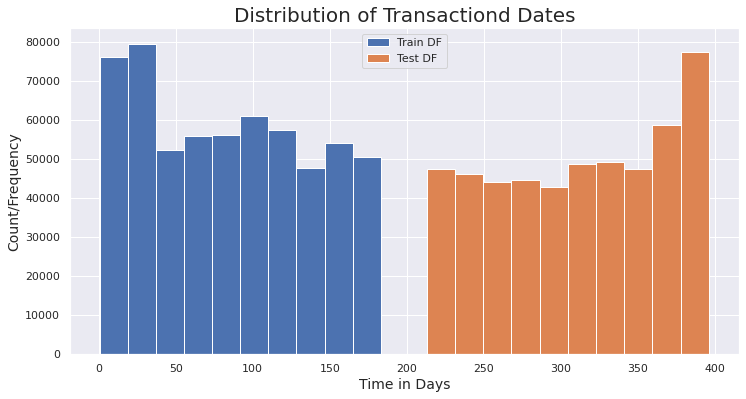

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(train_raw['TransDT_day'], label='Train DF')
plt.hist(test_raw['TransDT_day'], label='Test DF')
plt.legend()
plt.title('Distribution of Transactiond Dates', fontsize=20)
plt.xlabel ('Time in Days', fontsize=14)
plt.ylabel ('Count/Frequency', fontsize=14);

Due to size differential between the transaction and identity dataset, a large number of null values are expected.  Let's plot the percentate of null in the Train DF. 

In [ ]:
percent_notnull_by_col = train_raw.notnull().sum()/train_raw.shape[0]

fig = px.bar(y = train_raw.columns, x = percent_notnull_by_col, orientation='h',
             labels={'y':'Columns', 'x':'%Non_Null'}, height=1200,
             title='Percent of Non-Null Population by Columns')
fig.show()


**Observation#2** - In addition to the obvious high percentages of the null values in the dataset.  There is a definite pattern rather grouping of columns with the same percentage of null values.  This may indicate that the columns within the same group are likely from the same source.

**Observation#3** - Another interesting pattern is the high concentration of values within the columns.  That is, the mode value often dominates the distribution of values within the columns, often exceeding 70% or higher.  This is true when the fact that this merged data overstates the features from identity data.

Let's examine the histogram of these columns:

In [ ]:
def normalized_histo(df, cols=list):
  fig, axes = plt.subplots(2,3)
  axe = axes.ravel()
  for i, col in enumerate(cols):
    df[col].plot.hist(ax=axe[i])
    axe[i].title.set_text('{}'.format(col))
  plt.tight_layout()
  return 

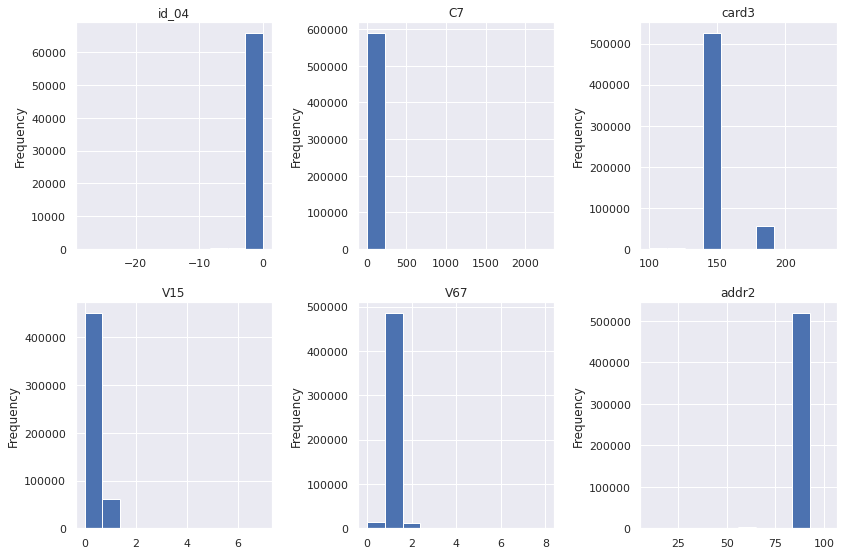

In [ ]:
normalized_histo(train_raw, ['id_04', 'C7', 'card3', 'V15', 'V67', 'addr2'])

**Observation#4** - in light of high null counts in the dataset, we may need to drop high null percentage columns.  If we are to set a maximum null percentage cut-off limit, we would want to know how many columns will be dropped as a result. 

In [ ]:
def high_null_cols(df, cut_off):
  high_null_cols = [col for col in df.columns if (df[col].isnull().sum()/df.shape[0]) >= cut_off]
  return high_null_cols

In [ ]:
def drop_col_in_df(df):
  print("From the total number of {} columns, the number of columns to be dropped at the null percentage cut-off are:".format(df.shape[1]))
  for i in range(1, 10, 1):
    drop_cols = high_null_cols(df, i/10)
    num_cols = len(drop_cols)
    print("At the cut-off of {0:0}% null count, {1} column(s)".format((i*10), num_cols))
  return

In [ ]:
drop_col_in_df(train_trans)

From the total number of 394 columns, the number of columns to be dropped at the null percentage cut-off are:
At the cut-off of 10% null count, 282 column(s)
At the cut-off of 20% null count, 212 column(s)
At the cut-off of 30% null count, 192 column(s)
At the cut-off of 40% null count, 192 column(s)
At the cut-off of 50% null count, 174 column(s)
At the cut-off of 60% null count, 168 column(s)
At the cut-off of 70% null count, 168 column(s)
At the cut-off of 80% null count, 55 column(s)
At the cut-off of 90% null count, 2 column(s)


In [ ]:
drop_col_in_df(train_id)

From the total number of 434 columns, the number of columns to be dropped at the null percentage cut-off are:
At the cut-off of 10% null count, 190 column(s)
At the cut-off of 20% null count, 187 column(s)
At the cut-off of 30% null count, 187 column(s)
At the cut-off of 40% null count, 187 column(s)
At the cut-off of 50% null count, 129 column(s)
At the cut-off of 60% null count, 36 column(s)
At the cut-off of 70% null count, 35 column(s)
At the cut-off of 80% null count, 30 column(s)
At the cut-off of 90% null count, 30 column(s)


**Observation#5** - Often it is recommended that in ML, it is better to drop columns if the column has more than 40% null values.  In our case, that would be 168 columns, a significant data loss.

In [ ]:
#calculates the percent null, fraud rates in null vs non-null population, unique count, mode representation
# within the non-null population for ALL columns in given dataframe
def percent_null_fraud(df):
  new_col_vals =[]
  for col in df.columns:
    p_null_fraud = (df[col].isna() & df.isFraud == 1).sum()/df[col].isnull().sum()
    p_not_null_fraud = (df[col].notnull() & df.isFraud == 1).sum()/df[col].notnull().sum()
    p_null = df[col].isna().sum()/df.shape[0]
    mode_percent = df[col].value_counts(dropna=False, normalize=True).values[0] 
    temp_lst = (col, p_null, p_null_fraud, p_not_null_fraud, len(df[col].unique()),
                mode_percent
                )
    new_col_vals.append(temp_lst)
  null_fraud_df = pd.DataFrame(new_col_vals)
  null_fraud_df.rename(columns ={0:'col_name', 1:'percent_null', 2:"f_rate_in_null_pop", 
                                 3:"f_rate_in_non_null_pop", 4: "unique_count",
                                 5:'mode_percent'
                                 }, inplace=True)
  # 'percent_null' refers to the proportion of null values in given column
  # 'f_rate_in_null_pop' refers to the fraud rate among null values
  # 'f_rate_in_non_null_pop' refers to the raud rate among null values
  return null_fraud_df
  


In [ ]:
null_fraud_df = percent_null_fraud(train_raw)

<ipython-input-21-37a836145197>:6: RuntimeWarning: invalid value encountered in long_scalars
  p_null_fraud = (df[col].isna() & df.isFraud == 1).sum()/df[col].isnull().sum()


In [ ]:
#calculates the fraud rates in the top 5 values within a given column
def top5_var_f_rate(col):
  mt_lst =[]
  col_dict = (train_raw[col].value_counts().head()).to_dict()
  for i in range(0,5):
    try:
      b = list(col_dict)[i]
      c = ((train_raw[col]==b) & (train_raw.isFraud == 1)).sum()/(train_raw[col]==b).sum() 
      d = [b, c]
      mt_lst.append(d)
    except IndexError:
      pass
  return mt_lst
    

In [ ]:
# using the function 'top5_var_f_rate()' function, we calculate the fraud rate within every column in a given df
def df_f_rate(df):
  col_f_rate_list = []
  for col in df.columns:
    a = top5_var_f_rate(col)
    col_f_rate_list.append(a)
  col_f_rate_df = pd.DataFrame(col_f_rate_list)
  col_f_rate_df['col_name'] = df.columns
  return col_f_rate_df


In [ ]:
col_f_rate_df = df_f_rate(train_raw)
col_f_rate_df.head()

,0,1,2,3,4,col_name
0,"[2987000, 0.0]","[3380885, 0.0]","[3380689, 0.0]","[3380690, 0.0]","[3380691, 0.0]",TransactionID
1,"[-5.0, 0.057965194109772425]","[0.0, 0.04975709537202761]","[-10.0, 0.1193923780758639]","[-20.0, 0.1254125412541254]","[-15.0, 0.11438138879097638]",id_01
2,"[1102.0, 0.0]","[696.0, 0.0]","[1141.0, 0.0]","[1117.0, 0.1111111111111111]","[1083.0, 0.0]",id_02
3,"[0.0, 0.1015288797083079]","[1.0, 0.19119351100811124]","[3.0, 0.18862275449101795]","[2.0, 0.28741092636579574]","[5.0, 0.5137614678899083]",id_03
4,"[0.0, 0.10594928429090798]","[-5.0, 0.09848484848484848]","[-6.0, 0.11224489795918367]","[-8.0, 0.46875]","[-4.0, 0.1568627450980392]",id_04


The results from the two functions are combined to create a new dataframe which will be coverted into an Excel file for convenient viewing & analysis. 

In [ ]:
for_column_analysis_df = pd.merge(null_fraud_df, col_f_rate_df, on='col_name')
for_column_analysis_df.columns = [[
    'col_name', 'percent_null','f_rate_in_null_pop','f_rate_in_non_null_pop', 
    'unique_count', 'mode_%Total', 'mode_1:f_rate', 'mode_2:f_rate', 'mode_3:f_rate', 'mode_4:f_rate', 'mode_5:f_rate']
    ]
for_column_analysis_df.head()

,col_name,percent_null,f_rate_in_null_pop,f_rate_in_non_null_pop,unique_count,mode_%Total,mode_1:f_rate,mode_2:f_rate,mode_3:f_rate,mode_4:f_rate,mode_5:f_rate
0,TransactionID,0.000000,NaN,0.034990,590540,0.000002,"[2987000, 0.0]","[3380885, 0.0]","[3380689, 0.0]","[3380690, 0.0]","[3380691, 0.0]"
1,id_01,0.755761,0.020939,0.078470,78,0.755761,"[-5.0, 0.057965194109772425]","[0.0, 0.04975709537202761]","[-10.0, 0.1193923780758639]","[-20.0, 0.1254125412541254]","[-15.0, 0.11438138879097638]"
2,id_02,0.761452,0.020995,0.079661,115656,0.761452,"[1102.0, 0.0]","[696.0, 0.0]","[1141.0, 0.0]","[1117.0, 0.1111111111111111]","[1083.0, 0.0]"
3,id_03,0.887689,0.025850,0.107231,25,0.887689,"[0.0, 0.1015288797083079]","[1.0, 0.19119351100811124]","[3.0, 0.18862275449101795]","[2.0, 0.28741092636579574]","[5.0, 0.5137614678899083]"
4,id_04,0.887689,0.025850,0.107231,16,0.887689,"[0.0, 0.10594928429090798]","[-5.0, 0.09848484848484848]","[-6.0, 0.11224489795918367]","[-8.0, 0.46875]","[-4.0, 0.1568627450980392]"


In [ ]:
for_column_analysis_df.to_excel("IEEE_C_Card_Fraud_Worksheet.xlsx")

Below is a screenshot of the Excel file 

<img src="https://imgur.com/6L2kEYZ.png" width="1200" height="500">




In [ ]:
fraud_excel_df = pd.read_excel('/content/IEEE_C_Card_Fraud_Worksheet.xlsx')
fraud_excel_df.drop(labels=0, axis=0, inplace=True)
fraud_excel_df.drop(labels= "Unnamed: 0", axis=1, inplace=True)
fraud_excel_df.head()

,col_name,dtype,percent_null,f_rate_in_null_pop,f_rate_in_non_null_pop,unique_count,mode_%Total,mode_1,f_rate,mode_2,f_rate.1,mode_3,f_rate.2,mode_4,f_rate.3,mode_5,f_rate.4
1,TransactionID,<class 'numpy.int32'>,0.000000,NaN,0.034990,590540.0,1.000000,2987000,0.000000,3380885,0.000000,3380689,0.000000,3380690,0.000000,3380691,0.000000
2,id_01,<class 'numpy.float32'>,0.755761,0.020939,0.078470,78.0,0.569703,-5,0.057965,0,0.049757,-10,0.119392,-20,0.125413,-15,0.114381
3,id_02,<class 'numpy.float32'>,0.761452,0.020995,0.079661,115656.0,0.000078,1102,0.000000,696,0.000000,1141,0.000000,1117,0.111111,1083,0.000000
4,id_03,<class 'numpy.float32'>,0.887689,0.025850,0.107231,25.0,0.963497,0,0.101529,1,0.191194,3,0.188623,2,0.287411,5,0.513761
5,id_04,<class 'numpy.float32'>,0.887689,0.025850,0.107231,16.0,0.991180,0,0.105949,-5,0.098485,-6,0.112245,-8,0.468750,-4,0.156863


In [ ]:
fraud_excel_df.describe()

,percent_null,f_rate_in_null_pop,f_rate_in_non_null_pop,unique_count,mode_%Total,f_rate,f_rate.1,f_rate.2,f_rate.3,f_rate.4
count,486.000000,462.000000,486.000000,486.000000,486.000000,486.000000,486.000000,458.000000,452.000000,438.000000
mean,0.464573,0.045429,0.052061,6915.878601,0.714871,0.042271,0.087594,0.143152,0.188701,0.201356
std,0.366065,0.036318,0.023714,46804.499870,0.296787,0.024669,0.098756,0.168268,0.242649,0.255437
min,0.000000,0.018572,0.019617,2.000000,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.039161,0.022758,0.034800,12.000000,0.601838,0.025349,0.030070,0.037167,0.027965,0.037568
50%,0.586342,0.033563,0.035523,56.000000,0.850659,0.033912,0.060881,0.082748,0.086800,0.092605
75%,0.779134,0.052122,0.078142,1317.750000,0.922301,0.050959,0.107830,0.187669,0.228428,0.247464
max,0.991970,0.166667,0.148778,590540.000000,1.000000,0.211592,1.000000,0.935484,1.000000,1.000000


In [ ]:
fig = px.bar(fraud_excel_df, 
             x = 'col_name', 
             y = ['f_rate_in_null_pop', 'f_rate_in_non_null_pop'],
             labels={'f_rate_in_null_pop':'Null Population','f_rate_in_non_null_pop':'Non-Null Population', 
                     'col_name':'Columns', 'value':'Fraud Rate'},
             title='Fraud Rate in Null vs Non-Null Population',
             barmode='overlay'
             )
fig.update_layout(yaxis_tickformat=".2%")
newnames = {'f_rate_in_null_pop':'Null Population','f_rate_in_non_null_pop':'Non-Null Population'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     ))

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.45
))

fig.show()

**Observation#6** - Whether there is information on the transaction or not, therefore, defining null vs non-null population, is a powerful differentiating factor. 

In [ ]:
fig = px.bar(fraud_excel_df, 
             x = 'col_name', 
             y = 'mode_%Total',
             labels={'mode_%Total':'',
                     'col_name':'Columns', 'value':'Fraud Rate'},
             title='Mode as Percent of Total (dropna=False)',
             barmode='overlay'
             )
fig.update_layout(yaxis_tickformat=".2%")
fig.show()

**Observation#7** - In the above graph, null values are included as a variable, i.e. 'dropna=False'. As previously discussed, the mode value within a column dominates the distribution  in many instances.  As null values included as a varaible of its own, those that display high null counts are over represented in the graph.  These columns that have high concentration of mode value will be removed from the predictive model building as the columns in this case behave like a single value column. 

In [ ]:
fig = px.bar(fraud_excel_df, 
             x = 'col_name', 
             y = ['f_rate', 'f_rate.1', 'f_rate.2'],
             labels={'f_rate':'Mode_1', 'f_rate.1':'Mode_2', 'f_rate.2':'Mode_3',
                     'col_name':'Columns', 'value':'Fraud Rate'},
             title='Fraud Rate in Top 3 Modes',
             barmode='overlay'
             )
fig.update_layout(yaxis_tickformat=".2%")
newnames = {'f_rate':'Mode_1', 'f_rate.1':'Mode_2', 'f_rate.2':'Mode_3'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     ))

fig.show()

**Observation#8** Although it is not clear, what we found frequently is that the fraud rate found within each mode is sequential, either increasing or decreasing.  This indicates that there is certain sequential order of predictive power of each variable, i.e. mode, in columns.

In [ ]:
train_raw = train_raw.rename({'TransactionDT_D':'TransDT_day'}, axis=1)
test_raw = test_raw.rename({'TransactionDT_D':'TransDT_day'}, axis=1)


# **Feature Engineering**

## P_emaildomain & R_emaildomain

Two categorical data columns, "P_emaildomain" (purchaser's provided email domain) & "R_emaildomain" (recipient's provided email domain), are numerous in unique values with many null values as well.  An interesting observation is the fraud rate is higher in case when the two columns match vs non-match by a factor of almost 4x.  

First, we examine the fraud rate within null vs. non-null population within each feature.

In [ ]:
def f_rate_null_non_null(df, col):
  a = ((df[col].isnull()) & (df.isFraud == 1)).sum()/(df[col].isnull()).sum()
  b = ((df[col].notnull()) & (df.isFraud == 1)).sum()/(df[col].notnull()).sum()
  print("Fraud rate for the {0} Null Population is {1:.2f}%".format(col, a*100))  
  print("Fraud rate for the {0} Non-Null Population is {1:.2f}%".format(col, b*100))
  return

In [ ]:
f_rate_null_non_null(train_trans, 'P_emaildomain')

Fraud rate for the P_emaildomain Null Population is 2.95%
Fraud rate for the P_emaildomain Non-Null Population is 3.60%


We observe no major difference in the fraud rates within the two population.

In [ ]:
f_rate_null_non_null(train_trans, 'R_emaildomain')

Fraud rate for the R_emaildomain Null Population is 2.08%
Fraud rate for the R_emaildomain Non-Null Population is 8.18%


But we do notice that the fraud rate within non-null population is much higher.  We can imply that fraudsters are more likely to provide recipient email domain.

One might assume that the fraudster are unlikely to provide matching email addresses for purchasing & receiving.  Let's see if that is the case:

In [ ]:
def P_R_emaildomain_match(df):
  col = df.apply(lambda row: \
                 (False if ((pd.notnull(row.P_emaildomain) == False) | \
                            (pd.notnull(row.R_emaildomain) == False) | \
                            (row.P_emaildomain != row.R_emaildomain)) \
                  else True),
                  axis=1)
  return col

In [ ]:
train_trans['P_R_emaildomain_match'] = P_R_emaildomain_match(train_trans)
test_trans['P_R_emaildomain_match'] = P_R_emaildomain_match(test_trans)
train_id['P_R_emaildomain_match'] = P_R_emaildomain_match(train_id)
test_id['P_R_emaildomain_match'] = P_R_emaildomain_match(test_id)

In [ ]:
train_trans['P_R_emaildomain_match'].sample(10, random_state=42)

In [ ]:
train_trans['P_emaildomain'].sample(10, random_state=42)

In [ ]:
train_trans['R_emaildomain'].sample(10, random_state=42)

Comparing these samples (random_state=42), the code is correct.

In [ ]:
train_trans['P_R_emaildomain_match'].value_counts()

In [ ]:
test_trans['P_R_emaildomain_match'].value_counts()

In [ ]:
mismatch_domain = ((train_trans['P_R_emaildomain_match']==False) & (train_trans.isFraud == 1))\
.sum()/(train_trans['P_R_emaildomain_match']==False).sum()
match_domain = ((train_trans['P_R_emaildomain_match']==True) & (train_trans.isFraud == 1))\
.sum()/(train_trans['P_R_emaildomain_match']==True).sum()
print("Fraud rate for the mismatching e-mail domain is {0:.2f}%".format(mismatch_domain*100))
print("Fraud rate for the matching e-mail domain is {0:.2f}%".format(match_domain*100))

Fraud rate for the mismatching e-mail domain is 2.21%
Fraud rate for the matching e-mail domain is 9.65%


It seems like the fraudsters are likely to provide the matching e-mail address. 

## Foreign Transaction

For those TransactionAmt which have 3 decimal places, it is assumed that the transaction is originated internationally, i.e. foreign transaction.  The foreign transaction amounts are converted into the US dollars by applying foreign exchange rates and rounded-off to the third decimal point. These foreign transactions will be detected and categorize into "F" for foreign transactions; the others will be categorized into "D" for domestic transactions.

In [ ]:
def TransAmt_Foreign(df):
  df['foreign_trans'] = df.TransactionAmt.astype(str).str.split(".", n=1, expand=True)[1]
  df.foreign_trans = ['F' if len(x) == 3 else 'D' for x in df.foreign_trans]
  return df.foreign_trans


In [ ]:
TransAmt_Foreign(train_trans)
TransAmt_Foreign(test_trans)
TransAmt_Foreign(train_id)
TransAmt_Foreign(test_id)

0         F
1         D
2         F
3         F
4         F
         ..
141902    F
141903    F
141904    D
141905    F
141906    F
Name: foreign_trans, Length: 141907, dtype: object

In [ ]:
train_trans['foreign_trans'].value_counts()

D    528607
F     61933
Name: foreign_trans, dtype: int64

In [ ]:
test_trans['foreign_trans'].value_counts()

D    445192
F     61499
Name: foreign_trans, dtype: int64

In [ ]:
dom_f_rate = ((train_trans['foreign_trans']=="D") & (train_trans.isFraud == 1))\
.sum()/(train_trans['foreign_trans']=="D").sum()
for_f_rate = ((train_trans['foreign_trans']=="F") & (train_trans.isFraud == 1))\
.sum()/(train_trans['foreign_trans']=="F").sum()
print("Fraud rate for the domestic transaction is {0:.2f}%".format(dom_f_rate*100))
print("Fraud rate for the foreign transaction is {0:.2f}%".format(for_f_rate*100))

Fraud rate for the domestic transaction is 2.54%
Fraud rate for the foreign transaction is 11.72%


What we notice is that these foreign transactions show higher fraud rate than otherwise. 

## TransactionAmt t-statics Applied to Categorical Features

This feature engineering is inspired by one of the participants (ANDREW LUKYANENKO) of this competition who calculated the grouped mean of TransactionAmt for each group of categorical features. I took this a step further and calculated the t-value of t-statics for each variable in each group within a column.  Although this method does not yield accurate t-value, it does give an approximation of the t-value.  The t-value in this case points to the position of each transaction within the t-distribution of that categorical grouping. 

To put this into layman's terms, it is assumed that fraudsters are more likely to make large value transactions before being discovered of their fraudulent behavior.  Therefore, one can detect potential frauds by examining unusually large transaction volume, i.e. high t-value. 




In [ ]:
# the code below calculates the t-statics which is used to detect unusual spending behavior 
def cat_transAmt_t_stat(df, col):
  df[col+'_transAmt_t_stat'] = df.groupby(col)['TransactionAmt'].transform(lambda row: (row-row.mean())/row.sem())
  return df[col+'_transAmt_t_stat']

In [ ]:
train_trans.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'P_R_emaildomain_match', 'foreign_trans'],
      dtype='object', length=396)

'identified_cat_cols' are the list of columns which the data provider identified as categorical columns.

In [ ]:
identified_cat_cols1 = ['ProductCD','card1','card2','card3','card4','card5',
            'card6','addr1','addr2','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9',
            ]

In [ ]:
identified_cat_cols = ['id_12','id_13','id_14','id_15','id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23',
            'id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_34','id_35',
            'id_36','id_37','id_38','DeviceType','DeviceInfo','ProductCD','card1','card2','card3','card4','card5',
            'card6','addr1','addr2','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9',
            ]

In [ ]:
%%time
for col in identified_cat_cols1:
  cat_transAmt_t_stat(train_trans, col)

CPU times: user 12.9 s, sys: 370 ms, total: 13.2 s
Wall time: 12.8 s


In [ ]:
for col in identified_cat_cols1:
  cat_transAmt_t_stat(test_trans, col)

In [ ]:
%%time
for col in identified_cat_cols:
  cat_transAmt_t_stat(train_id, col)

CPU times: user 10.2 s, sys: 237 ms, total: 10.4 s
Wall time: 10.1 s


In [ ]:
for col in identified_cat_cols:
  cat_transAmt_t_stat(test_id, col)

## Feature 'V258' applied to 'card_xx' features
Without any significant feature engineering, the data were ran through RandomForest and XGBoost models which yielded an intersting observation.  In both models, 'V258' was found to be the most powerful feature.  One weakness of 'V258' is that it has a large number of null values. Therefore, 'V258' will be feature engineered with 'card_xx' features, in particular 'card1' which does not have any null values.  The logic being that the information revealed in 'V258' will be transferable to card_xx features, in particular,  'card1'.

In [ ]:
f_rate_null_non_null(train_trans, 'V258')

Fraud rate for the V258 Null Population is 2.28%
Fraud rate for the V258 Non-Null Population is 7.81%


In [ ]:
def card_to_V258_stat(df, ccol):
  ''' this function assign V258 values to card_xx series.  V258 is proven to be
  very effective in identifying fraudualent transaction.  Then any card info (thus card_xxx series) associated
  with V258 can be effectively evaluated for being fraud. '''
  df[ccol+'_V258_mean'] = df.groupby(ccol)['V258'].transform('mean')
  df[ccol+'_V258_std'] = df.groupby(ccol)['V258'].transform('std')
  return df[ccol+'_V258_mean'], df[ccol+'_V258_std']

  

In [ ]:
card_xx = ['card1','card2','card3','card5']

In [ ]:
for col in card_xx:
  card_to_V258_stat(train_trans, col)

In [ ]:
for col in card_xx:
  card_to_V258_stat(test_trans, col)

In [ ]:
for col in card_xx:
  card_to_V258_stat(test_id, col)

In [ ]:
for col in card_xx:
  card_to_V258_stat(train_id, col)

In [ ]:
print('test_id shape',test_id.shape)
print('test_transaction shape', test_trans.shape)
print('train_id shape', train_id.shape)
print('train_transaction shape', train_trans.shape)

test_id shape (141907, 491)
test_transaction shape (506691, 422)
train_id shape (144233, 492)
train_transaction shape (590540, 423)


In [ ]:
lst_diff(train_id.columns, test_id.columns)

Index(['isFraud'], dtype='object')

# **Data Preparation for Modeling**

**Drop Columns**: we set a couple rules for removing columns:
1.   'too_many_null_cols' is a list of columns that has over 90% null values
2.   'high_mode_concentration_cols' is a list of columns in which the mode dominates that value distribution, i.e. over 90%, making the column effectively a single variable columns.
3.  There are columns which have nominal values i.e. 'TransactionID', or any miscellaneous or redundant columns. 

Later more columns may be dropped once the multi-collinearity becomes an issue. 




In [ ]:
#cut_off refer to the percentage of nulls in a column
def high_null_cols(df, cut_off):
  return [col for col in df.columns if ((df[col].isnull().sum()/df.shape[0]) > cut_off)]
  

In [ ]:
hinull_cols_test = high_null_cols(test_trans, .9)
hinull_cols = high_null_cols(train_trans, .9)
hinull_cols_test_id = high_null_cols(test_id, .9)
hinull_cols_id = high_null_cols(train_id, .9)

In [ ]:
#high mode concentration columns
def high_mode_freq_cols(df):
  return  [col for col in df.columns if df[col].\
                            value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [ ]:
himode_cols = high_mode_freq_cols(train_trans)
himode_cols_test = high_mode_freq_cols(test_trans)
himode_cols_id = high_mode_freq_cols(train_id)
himode_cols_test_id = high_mode_freq_cols(test_id)

## **Indentifying the Inputs & Target**

Combining the high_null_cols & high_mode_cols in both train and test datasets, the drop_cols are determined. In addition, a known ordinal/nimonal value feature ('TransactionID' & 'TransactionTD') are added to the 'drop_cols' list.

In [ ]:
drop_cols_trans = list(set().union([*hinull_cols_test, *hinull_cols, *himode_cols_test, *himode_cols, ]))
drop_cols_trans.extend(['TransactionID', 'TransactionDT'])
drop_cols_trans.remove('isFraud')


In [ ]:
drop_cols_id = list(set().union([*hinull_cols_test_id, *hinull_cols_id, *himode_cols_test_id, *himode_cols_id]))
drop_cols_id.extend(['TransactionID', 'TransactionDT'])
drop_cols_id.remove('isFraud')


Target feature is 'isFraud' in which fraudulent transaction is identified with value "1" vs non-fraudulent with "0".

In [ ]:
target_col = ['isFraud']

Removing both 'drop_cols' & 'target_col' from the dataset column lists, we arrive at the 'input_cols'.  We check to make sure the counts of columns are right.

In [ ]:
input_cols_id = [col for col in train_id.columns if col not in drop_cols_id]
input_cols_id.remove('isFraud')


In [ ]:
input_cols_trans = [col for col in train_trans.columns if col not in drop_cols_trans]
input_cols_trans.remove('isFraud')

In [ ]:
print("the number of columns in 'drop_col' is ",len(drop_cols_id))
print("the number of columns in 'input_col_id' is ",len(input_cols_id))
print("the number of columns in 'target_col' is ",len(target_col))
print("the number of columns in 'train_id' is ", len(train_id.columns))

the number of columns in 'drop_col' is  138
the number of columns in 'input_col_id' is  354
the number of columns in 'target_col' is  1
the number of columns in 'train_id' is  493


In [ ]:
print("the number of columns in 'drop_col' is ",len(drop_cols_trans))
print("the number of columns in 'input_col_trans' is ",len(input_cols_trans))
print("the number of columns in 'target_col' is ",len(target_col))
print("the number of columns in 'train_trans' is ", len(train_trans.columns))

the number of columns in 'drop_col' is  74
the number of columns in 'input_col_trans' is  349
the number of columns in 'target_col' is  1
the number of columns in 'train_trans' is  424


After identifying the input & target columns, the dataset dataframe is split into inputs & targets.

In [ ]:
inputs_trans = train_trans[input_cols_trans].copy()
inputs_id = train_id[input_cols_id].copy()
target_trans = train_trans[target_col].copy()
target_id = train_id[target_col].copy()

test_inputs_trans = test_trans[input_cols_trans].copy()
test_inputs_id = test_id[input_cols_id].copy()


In [ ]:
inputs_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 287 entries, TransactionAmt to card5_V258_std
dtypes: bool(1), float64(278), int64(1), object(7)
memory usage: 1.3+ GB


'input_cols' are further split into categorical and numerical columns.  From the function below, the columns that intersects 'drop_cols' and 'identified_cat_col' are removed from 'identified_cat_cols' to arrive at _useful_ categorical columns, 'cat_cols'. 

In [ ]:
def num_col_def(df):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  numeric_df = df.select_dtypes(include=numerics)
  return list(numeric_df.columns)

In [ ]:
num_cols_trans = num_col_def(inputs_trans)
num_cols_id = num_col_def(inputs_id)

In [ ]:
cat_cols_trans = list(lst_diff(inputs_trans.columns, num_cols_trans))
cat_cols_id = list(lst_diff(inputs_id.columns, num_cols_id))

In [ ]:
print("the number of columns in 'cat_cols' in train_trans is ", len(cat_cols_trans))
print("the number of columns in 'num_cols' in train_trans is ", len(num_cols_trans))
print("the number of columns in 'input_col' in train_trans is ", len(input_cols_trans))


the number of columns in 'cat_cols' in train_trans is  16
the number of columns in 'num_cols' in train_trans is  333
the number of columns in 'input_col' in train_trans is  349


In [ ]:
print("the number of columns in 'cat_cols' in train_id is ", len(cat_cols_id))
print("the number of columns in 'num_cols' in train_id is ", len(num_cols_id))
print("the number of columns in 'input_col' in train_id is ", len(input_cols_id))


the number of columns in 'cat_cols' in train_id is  21
the number of columns in 'num_cols' in train_id is  290
the number of columns in 'input_col' in train_id is  311


## **Min-Max Scaler**

Next step is to scale the numerical features.  Before proceeding further, we use remove infinity values and convert them into np.nan values. 

In [ ]:
def clean_inf_nan(df):
  return df.replace([np.inf, -np.inf], np.nan) 

In [ ]:
inputs_trans = clean_inf_nan(inputs_trans)
inputs_id = clean_inf_nan(inputs_id)
test_inputs_trans = clean_inf_nan(test_inputs_trans)
test_inputs_id = clean_inf_nan(test_inputs_id)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(inputs_id[num_cols_id])

MinMaxScaler()

In [ ]:
inputs_id[num_cols_id] = scaler.transform(inputs_id[num_cols_id])
test_inputs_id[num_cols_id] = scaler.transform(test_inputs_id[num_cols_id])

In [ ]:
scaler.fit(inputs_trans[num_cols_trans])

MinMaxScaler()

In [ ]:
inputs_trans[num_cols_trans] = scaler.transform(inputs_trans[num_cols_trans])
test_inputs_trans[num_cols_trans] = scaler.transform(test_inputs_trans[num_cols_trans])

## **Imputing Null Values**
As discussed before most of the features in the datasets have a high percentage of null values often exceeding 70%~80% of total.  We have already removed the features or columns in which its null values exceed 90%.  If we are lower the standard, to say to 70%, the number of columns that need to be removed will 238.  However, considering that the placement of these null values do not necessary overlap along the same row, the actual removal of data will likely to approach 95% or more.  Therefore, employing a standard imputation method of row or columnal removal cannot be considered.

Various imputer techniques are considered - SimpleImputer, Interative Imputer, KNN Imputer, MissForest Imputer, MICE.  Considering the large percentage of null values in the dataset as well as the structural imbalance, SimpleImputer and KNN Imputers will not be considered due to heavy lack of data in most features. 

"Multivariate imputation by chained equations (MICE) is an iterative approach to impute missing values. It takes an assumption that the data are missing at random, and it makes an educated guess about its true value by looking into the other sample values." (Satyam Kumar, www.towardsdatascience.com on Feb 8, 2022).  Although this imputing technique is expected to be an improvement from the univariate imputation technique, SimpleImputer, it still depends on the availability of other features.  

MissForest Imputer is based on XGBoost Classifier & Regressor models which have proven to be most powerful tool in recent years. Moreover, it is considered the most efficient imputer technique by many.  Therefore, MissForest will be considered for this project.  

https://ragvenderrawat.medium.com/miss-forest-imputaion-the-best-way-to-handle-missing-data-feature-engineering-techniques-2e6922e5cecb

https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3

In [ ]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [ ]:
!pip install MissForest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from missforest.miss_forest import MissForest
mf = MissForest()

In [ ]:
inputs_trans = mf.fit_transform(inputs_trans)

In [ ]:
inputs_id = mf.fit_transform(inputs_id)

In [ ]:
test_inputs_trans = mf.fit_transform(test_inputs_trans)

In [ ]:
test_inputs_id  = mf.fit_transform(test_inputs_id)

In [ ]:
inputs_trans.isna().sum()

TransactionAmt     0
ProductCD          0
card1              0
card2              0
card3              0
                  ..
card2_V258_std     0
card3_V258_mean    0
card3_V258_std     0
card5_V258_mean    0
card5_V258_std     0
Length: 349, dtype: int64

In [ ]:
inputs_id.isna().sum()

id_01              0
id_02              0
id_03              0
id_04              0
id_05              0
                  ..
card2_V258_std     0
card3_V258_mean    0
card3_V258_std     0
card5_V258_mean    0
card5_V258_std     0
Length: 354, dtype: int64

In [ ]:
inputs_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 349 entries, TransactionAmt to card5_V258_std
dtypes: bool(1), float64(333), int64(15)
memory usage: 1.5 GB


In [ ]:
!pip install pandas-downcast
import pdcast as pdc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
inputs_trans = pdc.downcast(inputs_trans)
inputs_id = pdc.downcast(inputs_id)
test_inputs_trans = pdc.downcast(test_inputs_trans)
test_inputs_id = pdc.downcast(test_inputs_id)

In [ ]:
inputs_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 349 entries, TransactionAmt to card5_V258_std
dtypes: bool(12), float16(20), float32(311), uint8(6)
memory usage: 733.3 MB


## **One-Hot Encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder_trans = OneHotEncoder(sparse=False, handle_unknown='ignore' , min_frequency = .05).fit(inputs_trans[cat_cols_trans])
encoded_cols_trans = list(encoder_trans.get_feature_names_out(cat_cols_trans)) 

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
encoded_cols_trans

['M1_0',
 'M1_infrequent_sklearn',
 'M2_False',
 'M2_True',
 'M3_False',
 'M3_True',
 'M4_0',
 'M4_1',
 'M4_2',
 'M5_False',
 'M5_True',
 'M6_False',
 'M6_True',
 'M7_False',
 'M7_True',
 'M8_False',
 'M8_True',
 'M9_False',
 'M9_True',
 'P_R_emaildomain_match_False',
 'P_R_emaildomain_match_True',
 'P_emaildomain_0',
 'P_emaildomain_2',
 'P_emaildomain_4',
 'P_emaildomain_5',
 'P_emaildomain_infrequent_sklearn',
 'ProductCD_0',
 'ProductCD_1',
 'ProductCD_2',
 'ProductCD_4',
 'ProductCD_infrequent_sklearn',
 'R_emaildomain_0',
 'R_emaildomain_infrequent_sklearn',
 'card4_1',
 'card4_2',
 'card4_infrequent_sklearn',
 'card6_False',
 'card6_True',
 'foreign_trans_False',
 'foreign_trans_True']

In [ ]:
inputs_trans[encoded_cols_trans] = encoder_trans.transform(inputs_trans[cat_cols_trans])
test_inputs_trans[encoded_cols_trans] = encoder_trans.transform(test_inputs_trans[cat_cols_trans])

In [ ]:
encoder_id = OneHotEncoder(sparse=False, handle_unknown='ignore' , min_frequency = .05).fit(inputs_id[cat_cols_id])
encoded_cols_id = list(encoder_id.get_feature_names_out(cat_cols_id)) 

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
encoded_cols_id

['DeviceInfo_1',
 'DeviceInfo_2',
 'DeviceInfo_3',
 'DeviceInfo_18',
 'DeviceInfo_infrequent_sklearn',
 'DeviceType_False',
 'DeviceType_True',
 'M4_0',
 'M4_1',
 'M4_infrequent_sklearn',
 'P_R_emaildomain_match_False',
 'P_R_emaildomain_match_True',
 'P_emaildomain_0',
 'P_emaildomain_1',
 'P_emaildomain_2',
 'P_emaildomain_4',
 'P_emaildomain_infrequent_sklearn',
 'ProductCD_0',
 'ProductCD_1',
 'ProductCD_2',
 'ProductCD_3',
 'R_emaildomain_0',
 'R_emaildomain_1',
 'R_emaildomain_3',
 'R_emaildomain_8',
 'R_emaildomain_infrequent_sklearn',
 'card4_0',
 'card4_1',
 'card4_2',
 'card4_infrequent_sklearn',
 'card6_False',
 'card6_True',
 'foreign_trans_False',
 'foreign_trans_True',
 'id_12_False',
 'id_12_True',
 'id_15_0',
 'id_15_1',
 'id_15_2',
 'id_16_False',
 'id_16_True',
 'id_28_False',
 'id_28_True',
 'id_29_False',
 'id_29_True',
 'id_30_3',
 'id_30_12',
 'id_30_infrequent_sklearn',
 'id_31_1',
 'id_31_5',
 'id_31_9',
 'id_31_21',
 'id_31_52',
 'id_31_infrequent_sklearn',
 'i

In [ ]:
inputs_id[encoded_cols_id] = encoder_id.transform(inputs_id[cat_cols_id])
test_inputs_id[encoded_cols_id] = encoder_id.transform(test_inputs_id[cat_cols_id])

In [ ]:
X_train_trans = inputs_trans[num_cols_trans + encoded_cols_trans]
X_test_trans = test_inputs_trans[num_cols_trans + encoded_cols_trans]
X_train_id = inputs_id[num_cols_id + encoded_cols_id]
X_test_id = test_inputs_id[num_cols_id + encoded_cols_id]

In [ ]:
target_trans = train_trans['isFraud'].to_frame()
target_id = train_id['isFraud'].to_frame()

In [ ]:
X_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 373 entries, TransactionAmt to foreign_trans_True
dtypes: bool(2), float16(20), float32(311), float64(40)
memory usage: 904.5 MB


In [ ]:
X_test_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 373 entries, TransactionAmt to foreign_trans_True
dtypes: float16(20), float32(311), float64(40), uint8(2)
memory usage: 776.0 MB


In [ ]:
lst_diff(X_train_trans.columns, X_test_trans.columns) 

Index([], dtype='object')

In [ ]:
X_train_trans = pd.read_feather('/content/X_train_trans.feather')
X_train_id = pd.read_feather('/content/X_train_id.feather')
X_test_trans = pd.read_feather('/content/X_test_trans.feather')
X_test_id = pd.read_feather('/content/X_test_id.feather')
target_trans = pd.read_feather('/content/target_trans.feather')
target_id = pd.read_feather('/content/target_id.feather')

## **Train_Test Split**

For the ML model development, we will train-test split the data.

**X_train_trans** : Size of X_train_trans is large with a shape of (590540, 373), taking up 904.5MB memory.  Sampling rate will be 20%.  

**X_train_id** : Similarly, X_train_id will be sampled at 40%. 


In [ ]:
combo_trans = X_train_trans.join(target_trans)
combo_trans = combo_trans.sample(frac=.20, random_state=42)
target_trans_sample = combo_trans['isFraud']
train_trans_sample = combo_trans.drop('isFraud', axis=1)

Tran-Test Split for Model Building

In [ ]:
from sklearn.model_selection import train_test_split
train_t_inputs, val_t_inputs, train_t_targets, val_t_targets = train_test_split(
    train_trans_sample, target_trans_sample, test_size=0.25, random_state=42)

In [ ]:
combo_id = X_train_id.join(target_id)
combo_id = combo_id.sample(frac=.40, random_state=42)
target_id_sample = combo_id['isFraud']
train_id_sample = combo_id.drop('isFraud', axis=1)

In [ ]:
train_i_inputs, val_i_inputs, train_i_targets, val_i_targets = train_test_split(
    train_id_sample, target_id_sample, test_size=0.25, random_state=42)

# **RandomForest Classifier**

## **RandomForest Model for Transaction Data** 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#train_inputs, val_inputs, train_targets, val_targets 
rf_basemodel_tran = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
rf_basemodel_tran.fit(train_t_inputs,train_t_targets)


RandomForestClassifier(n_jobs=-1, random_state=42)

Below we create the baseline comparison for the model. 

In [ ]:
base_train_t_acc = rf_basemodel_tran.score(train_t_inputs,train_t_targets)
base_val_t_acc = rf_basemodel_tran.score(val_t_inputs, val_t_targets)
base_t_accs = base_train_t_acc, base_val_t_acc
print('BaseModel for Trans Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(base_train_t_acc *100, base_val_t_acc*100))

BaseModel for Trans Data: Train Accuracy Score: 99.997742%, Val Accuracy Score: 97.615742%


In [ ]:
bm_t_importance_df = pd.DataFrame({
    'feature': train_t_inputs.columns,
    'importance': rf_basemodel_tran.feature_importances_
}).sort_values('importance', ascending=False)

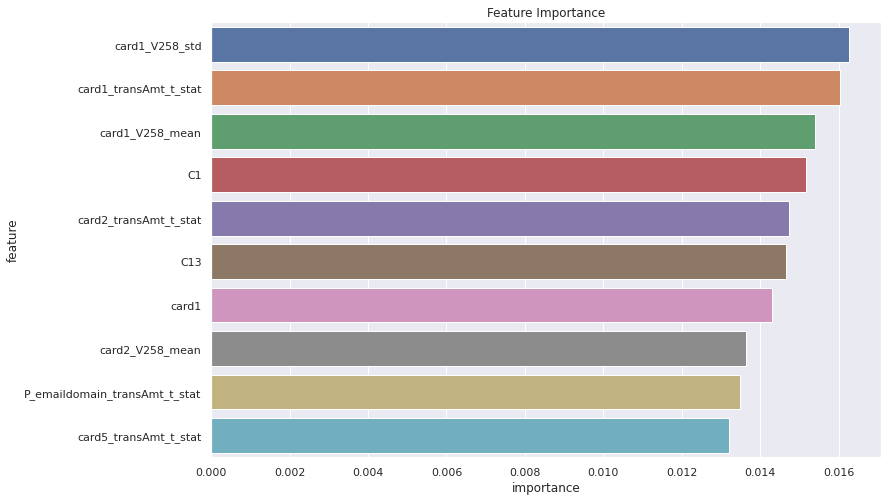

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=bm_t_importance_df.head(10), x='importance', y='feature');

### **Hyperparameter Tuning**

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    for x,y in zip(param_values, val_errors):
      label = "{:.5f}".format(y)
      plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 fontsize=9,
                 ha='center') # horizontal alignment can be left, right or center


In [ ]:
#Defining the train_inputs, train_target, val_inputs & val_targets definitions
train_inputs = train_t_inputs
train_targets = train_t_targets
val_inputs = val_t_inputs 
val_targets = val_t_targets

**max_depth** specifies the maximum depth of each tree in RandomForest trees.  Increasing the max_depth increases the model accuracy of the model upto certain point from which the model starts to overfit. 

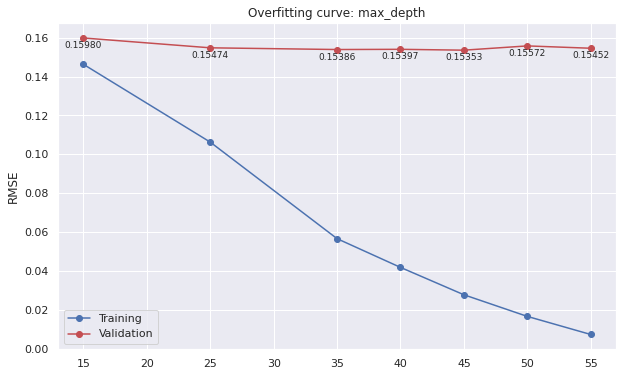

In [ ]:
#parameter = max_depth
test_param_and_plot('max_depth', [15, 25, 35, 40, 45, 50, 55])

The trend is not definitive but max_depth=**45** will be chosen as the optimized parameter value.

**n_estimators** is the number of trees one desires to build before taking the maximum voting or averages of predictions. Higher number of trees give better performance but makes the code slower. 

CPU times: user 8min 39s, sys: 1.8 s, total: 8min 41s
Wall time: 2min 36s


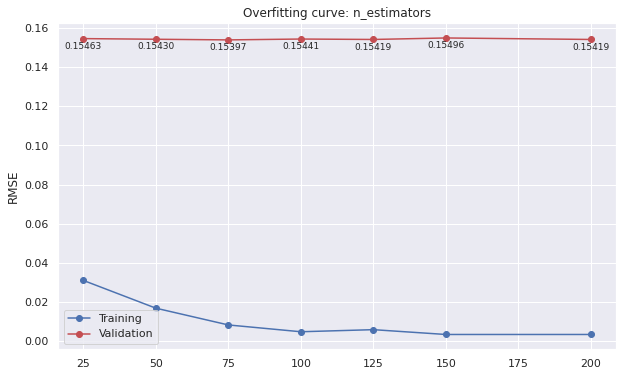

In [ ]:
#parameter  = n_estimators
%%time
test_param_and_plot('n_estimators', [25, 50, 75, 100, 125, 150, 200])

Again no clear trend is apparent, the optimal paranmeter value will be set to be **75**. 

**max_features** is the maximum number of features Random Forest is allowed to try in individual tree.  Although increasing the max_depth in general may increase the model accuracy, it comes at the cost of greater computing resource.

CPU times: user 27min 39s, sys: 1.85 s, total: 27min 41s
Wall time: 7min 48s


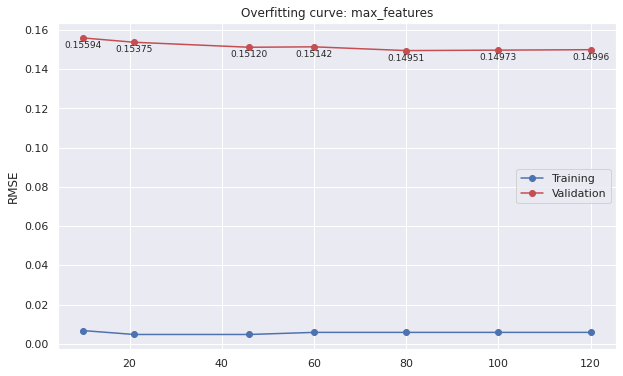

In [ ]:
#parameter = max_features
%%time
test_param_and_plot('max_features', [10, 21, 46, 60, 80, 100, 120])

Parameter value of max_feature=21 is to approximate, the default value of “sqrt” which is sqrt(n_features) = ~20.8.  

It seems that the optimal parameter value is **100**

### **Putting it together - RandomForest Model for Transaction Data**

Based on the hyperparameter tuning learning, we put them all together for the final model.  

In [ ]:
rf_trans_model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=75,
                               max_features=100,
                               max_depth=45)

**Tran-Test Split for Model Evaluation**

In [ ]:
X_train_t_inputs, X_val_t_inputs, X_train_t_targets, X_val_t_targets = train_test_split(
    X_train_trans, target_trans, test_size=0.25, random_state=42)

In [ ]:
%%time
rf_trans_model.fit(X_train_t_inputs, X_train_t_targets)

<timed eval>:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



CPU times: user 36min 41s, sys: 0 ns, total: 36min 41s
Wall time: 10min 6s


RandomForestClassifier(max_depth=40, max_features=100, n_estimators=75,
                       n_jobs=-1, random_state=42)

In [ ]:
X_train_t_acc = rf_trans_model.score(X_train_t_inputs, X_train_t_targets)
X_val_t_acc = rf_trans_model.score(X_val_t_inputs, X_val_t_targets)
print('Hypertuned Model: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(X_train_t_acc*100, X_val_t_acc*100))

Hypertuned Model: Train Accuracy Score: 99.534212%, Val Accuracy Score: 98.149490%


In [ ]:
print('BaseModel for Trans Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(base_train_t_acc *100, base_val_t_acc*100))

BaseModel for Trans Data: Train Accuracy Score: 99.997742%, Val Accuracy Score: 97.615742%


Compare to the base model, the hypertuned model yield 0.565% improvement.

In [ ]:
rf_trans_model_importance_df = pd.DataFrame({
    'feature': X_train_t_inputs.columns,
    'importance': rf_trans_model.feature_importances_
}).sort_values('importance', ascending=False)

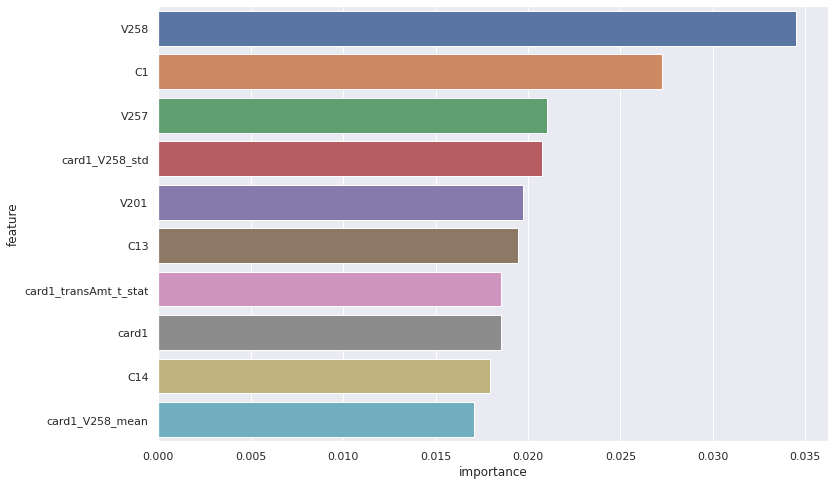

In [ ]:
sns.barplot(data=rf_trans_model_importance_df.head(10), x='importance', y='feature');

In [ ]:
rf_X_test_trans_preds = rf_trans_model.predict(X_test_trans)

In [ ]:
test_index_trans = test_trans[['TransactionID']]
rf_submission_trans = pd.DataFrame(data = rf_X_test_trans_preds, 
                  columns = ['isFraud'])
rf_submission_trans_df = test_index_trans.join(rf_submission_trans)
rf_submission_trans_df.sample(10)

,TransactionID,isFraud
272065,3935614,0
341806,4005355,0
74098,3737647,0
426334,4089883,0
317188,3980737,0
251805,3915354,0
270338,3933887,0
392247,4055796,0
419545,4083094,0
223284,3886833,0


## **RandomForest Model for Identity Data** 

In [ ]:
#train_inputs, val_inputs, train_targets, val_targets 
rf_basemodel_id = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
rf_basemodel_id.fit(train_i_inputs,train_i_targets)


RandomForestClassifier(n_jobs=-1, random_state=42)

Below we create the baseline comparison for the model. 

In [ ]:
base_train_i_acc = rf_basemodel_id.score(train_i_inputs,train_i_targets)
base_val_i_acc = rf_basemodel_id.score(val_i_inputs, val_i_targets)
base_i_accs = base_train_i_acc, base_val_i_acc
print('BaseModel for ID Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(base_train_i_acc *100, base_val_i_acc*100))

BaseModel for ID Data: Train Accuracy Score: 100.000000%, Val Accuracy Score: 96.519689%


In [ ]:
bm_i_importance_df = pd.DataFrame({
    'feature': train_i_inputs.columns,
    'importance': rf_basemodel_id.feature_importances_
}).sort_values('importance', ascending=False)

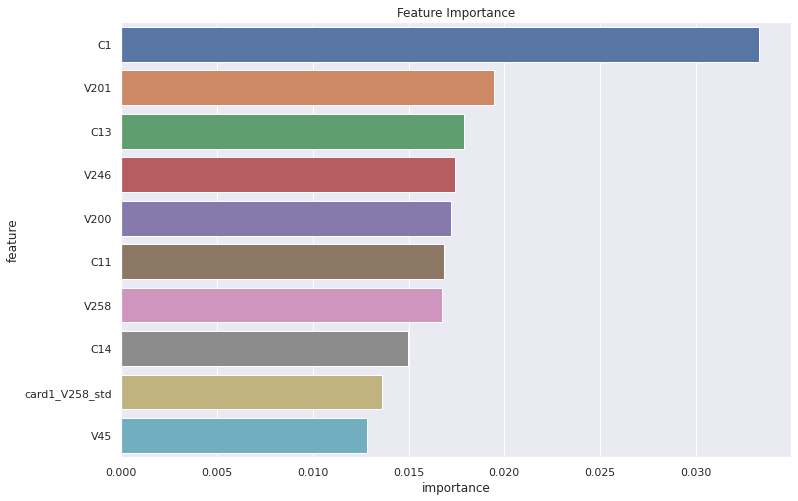

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=bm_i_importance_df.head(10), x='importance', y='feature');

### **Hyperparameter Tuning**

In [ ]:
#Defining the train_inputs, train_target, val_inputs & val_targets definitions
train_inputs = train_i_inputs
train_targets = train_i_targets
val_inputs = val_i_inputs 
val_targets = val_i_targets

**max_depth** specifies the maximum depth of each tree in RandomForest trees.  Increasing the max_depth increases the model accuracy of the model upto certain point from which the model starts to overfit. 

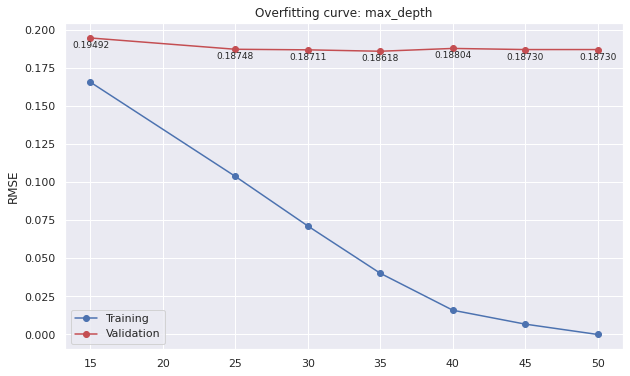

In [ ]:
#parameter = max_depth
test_param_and_plot('max_depth', [15, 25, 30, 35, 40, 45, 50])

The trend is not definitive but max_depth=**35** will be chosen as the optimized parameter value.

**n_estimators** is the number of trees one desires to build before taking the maximum voting or averages of predictions. Higher number of trees give better performance but makes the code slower. 

CPU times: user 4min 53s, sys: 945 ms, total: 4min 54s
Wall time: 1min 26s


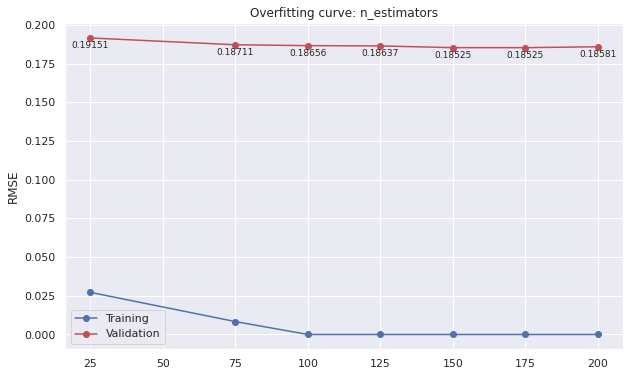

In [ ]:
#parameter  = n_estimators
%%time
test_param_and_plot('n_estimators', [25, 75, 100, 125, 150, 175, 200])

Since n_estimator=150 & 175 yield the same value, the optimal paranmeter value will be set in the middle, around **163**. 

**max_features** is the maximum number of features Random Forest is allowed to try in individual tree.  However, this decreases the diversity of individual tree which is the USP of random forest.

CPU times: user 15min 21s, sys: 1.06 s, total: 15min 22s
Wall time: 4min 5s


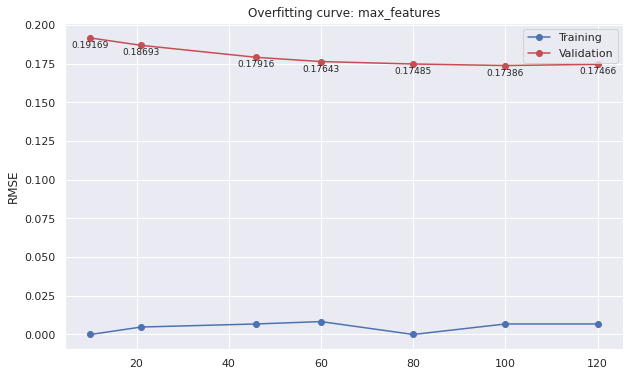

In [ ]:
#parameter = max_features
%%time
test_param_and_plot('max_features', [10, 21, 46, 60, 80, 100, 120])

Parameter value of max_feature=21 is to approximate, the default value of “sqrt” which is sqrt(n_features) = ~20.8.  

It seems that the optimal parameter value is **100**

### **Putting it together - RandomForest Model for Identity Data**

Based on the hyperparameter tuning learning, we put them all together for the final model.  

In [ ]:
rf_id_model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=75,
                               max_features=100,
                               max_depth=35)

**Tran-Test Split for Model Evaluation**

In [ ]:
X_train_i_inputs, X_val_i_inputs, X_train_i_targets, X_val_i_targets = train_test_split(
    X_train_id, target_id, test_size=0.25, random_state=42)

In [ ]:
%%time
rf_id_model.fit(X_train_i_inputs, X_train_i_targets)

<timed eval>:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



CPU times: user 4min 8s, sys: 327 ms, total: 4min 8s
Wall time: 1min 7s


RandomForestClassifier(max_depth=35, max_features=60, n_estimators=75,
                       n_jobs=-1, random_state=42)

In [ ]:
X_train_i_acc = rf_id_model.score(X_train_i_inputs, X_train_i_targets)
X_val_i_acc = rf_id_model.score(X_val_i_inputs, X_val_i_targets)
print('Hyper-tuned Model: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(X_train_i_acc*100, X_val_i_acc*100))

Hyper-tuned Model: Train Accuracy Score: 99.615434%, Val Accuracy Score: 97.223994%


In [ ]:
print('BaseModel for ID Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(base_train_i_acc *100, base_val_i_acc*100))

BaseModel for ID Data: Train Accuracy Score: 100.000000%, Val Accuracy Score: 96.519689%


Compare to the base model, the hypertuned model yield 0.831% improvement.

In [ ]:
rf_id_model_importance_df = pd.DataFrame({
    'feature': X_train_i_inputs.columns,
    'importance': rf_id_model.feature_importances_
}).sort_values('importance', ascending=False)

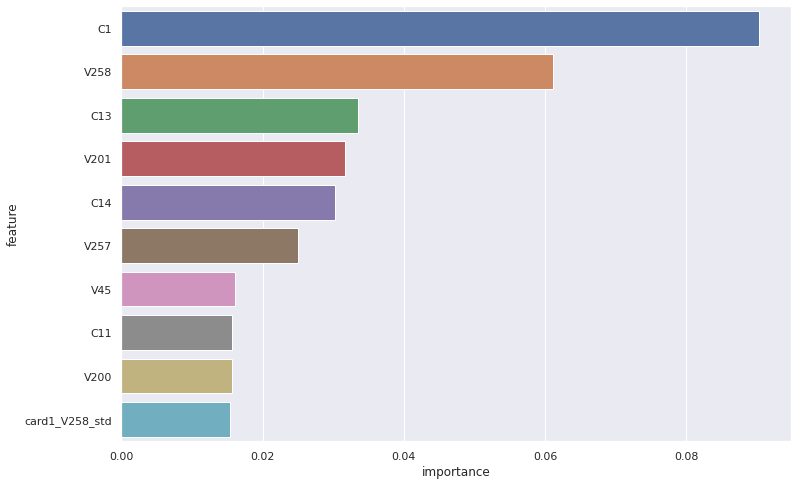

In [ ]:
sns.barplot(data=rf_id_model_importance_df.head(10), x='importance', y='feature');

In [ ]:
rf_trans_model_importance_df.head(10)

,feature,importance
243,V258,0.034488
8,C1,0.027246
242,V257,0.021012
326,card1_V258_std,0.020743
186,V201,0.019738
19,C13,0.019441
306,card1_transAmt_t_stat,0.018563
1,card1,0.018537
20,C14,0.017956
325,card1_V258_mean,0.017101


In [ ]:
rf_id_model_importance_df.head(10)

,feature,importance
23,C1,0.090293
227,V258,0.061129
32,C13,0.033515
175,V201,0.031686
33,C14,0.030275
226,V257,0.025029
74,V45,0.016077
30,C11,0.015675
174,V200,0.015605
325,card1_V258_std,0.015347


In [ ]:
rf_X_test_id_preds = rf_id_model.predict(X_test_id)

In [ ]:
test_index_id = test_id[['TransactionID']]
rf_submission_id = pd.DataFrame(data = rf_X_test_id_preds, 
                  columns = ['isFraud'])
rf_submission_id_df = test_index_id.join(rf_submission_id)
rf_submission_id_df.sample(10)

,TransactionID,isFraud
61327,3963241,0
72163,4006685,0
99785,4089639,0
40950,3883913,0
118261,4127501,0
113466,4118991,0
129416,4145978,0
29581,3825604,1
56923,3946810,0
80435,4034703,0


# **Gradient Descent - XGBoost**

## **XGBoost Model Building for Transaction Data**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
xgb_base_trans = XGBClassifier(n_jobs=-1, random_state=42)
print(xgb_base_trans)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [ ]:
%%time
xgb_base_trans.fit(train_t_inputs,train_t_targets)

CPU times: user 3min 9s, sys: 2.6 s, total: 3min 12s
Wall time: 58.7 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
xgb_base_train_t_acc = xgb_base_trans.score(train_t_inputs,train_t_targets)
xgb_base_val_t_acc = xgb_base_trans.score(val_t_inputs, val_t_targets)
print('BaseModel for Trans Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(xgb_base_train_t_acc *100, xgb_base_val_t_acc*100))

BaseModel for Trans Data: Train Accuracy Score: 98.629503%, Val Accuracy Score: 97.768144%


In [ ]:
xgb_t_base_importance_df = pd.DataFrame({
    'feature': train_t_inputs.columns,
    'importance': xgb_base_trans.feature_importances_
}).sort_values('importance', ascending=False)

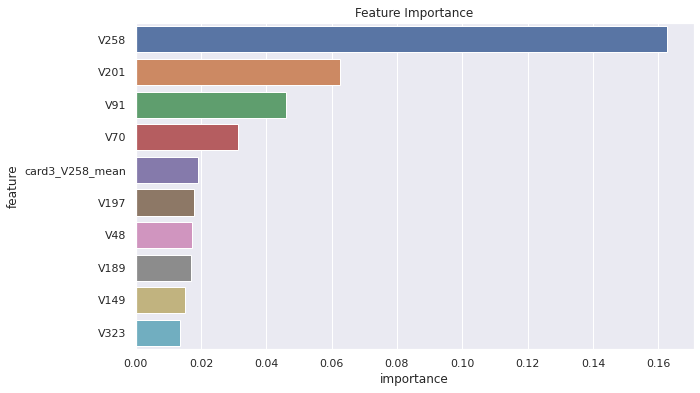

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=xgb_t_base_importance_df.head(10), x='importance', y='feature');

In [ ]:
#RandomForest hyper-parameter tuned model importance
rf_trans_model_importance_df.head(10)

,feature,importance
243,V258,0.034488
8,C1,0.027246
242,V257,0.021012
326,card1_V258_std,0.020743
186,V201,0.019738
19,C13,0.019441
306,card1_transAmt_t_stat,0.018563
1,card1,0.018537
20,C14,0.017956
325,card1_V258_mean,0.017101


Result from the XGBoost basemodel is different from the tuned RandomForest results in that most of important fearures consiste mostly of Vxxx features. 



### **Hyperparameter Tuning**


In [ ]:
#Defining the train_inputs, train_target, val_inputs & val_targets definitions
train_inputs = train_t_inputs
train_targets = train_t_targets
val_inputs = val_t_inputs 
val_targets = val_t_targets

In [ ]:
def xgb_test_params(**params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [ ]:
def xgb_test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = xgb_test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    for x,y in zip(param_values, val_errors):
      label = "{:.5f}".format(y)
      plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 fontsize=9,
                 ha='center') # horizontal alignment can be left, right or center


**max_depth** specifies the maximum depth of each tree in XGBoost trees.

CPU times: user 39min 37s, sys: 13 s, total: 39min 50s
Wall time: 10min 56s


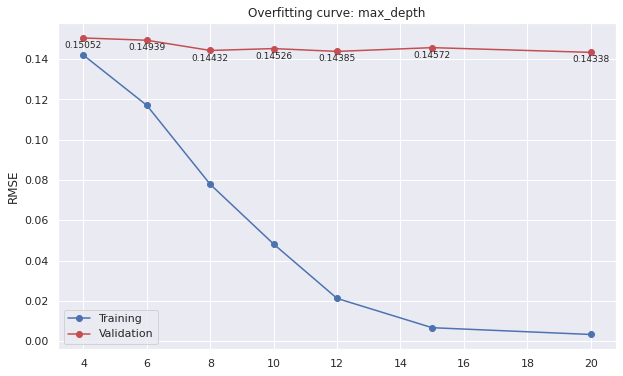

In [ ]:
%%time
xgb_test_param_and_plot('max_depth', [4, 6, 8, 10, 12, 15, 20])

Although max_depth=20 yields the lowest RSME but this seems like overfitting as RSME of training data is approaching near zero.  The optimal parameter will be set at 12 to be conservative. 

**n_estimators**

CPU times: user 17min 57s, sys: 8.69 s, total: 18min 6s
Wall time: 5min 6s


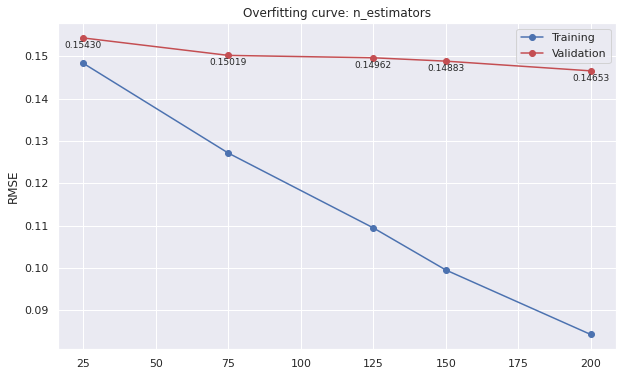

In [ ]:
%%time
xgb_test_param_and_plot('n_estimators', [25, 75, 125, 150, 200])

Higher the n_estimators, greater the accuracy. After n_estimator=75, the difference is marginal.  The default value of 100 will be kept. 

**Learning Rate** is inserted to limit the learning rate of gradient boosted desicion trees, thereby limiting the possibility of overfitting. 

CPU times: user 21min 57s, sys: 12.5 s, total: 22min 10s
Wall time: 6min 20s


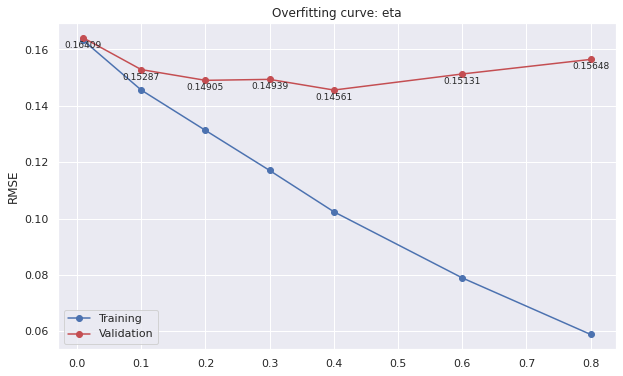

In [ ]:
%%time
xgb_test_param_and_plot('eta', [.01, .1, .2, .3, .4, .6, .8])

The optimal 'learning_rate', aka 'eta', seems to be 0.4

**gamma** specifies the minimum loss reduction required to make a split. A node is split only when the resulting split gives a positive reduction in the loss function.
Hence high parameter value of gamma makes the algorithm conservative. 

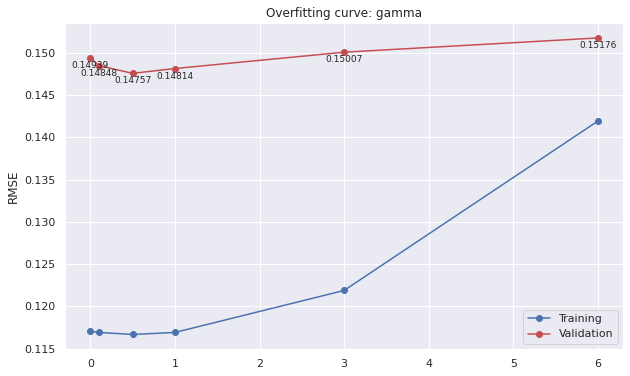

In [ ]:
xgb_test_param_and_plot('gamma', [0, 0.1, 0.5, 1, 3, 6])

The optimal value of gamma seems to be 0.5. 

**alpha** defines the L1 (Lasso regression) regularization term weights.  It can be used in case of very high dimensionality so that the algorithm runs faster when implemented.

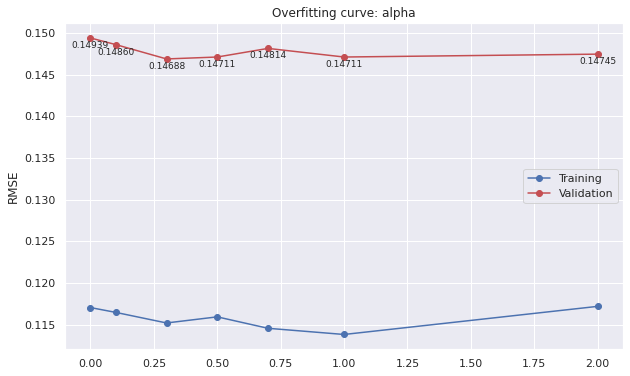

In [ ]:
xgb_test_param_and_plot('alpha', [0,.1,.3,.5,.7,1,2])

It is unclear what the optimal alpha parameter value is.  For now, the 0.3 will be chosen but will be reconsidered in relations to other parameters. 

**subsample** denotes the fraction of observations to be randomly samples for each tree.

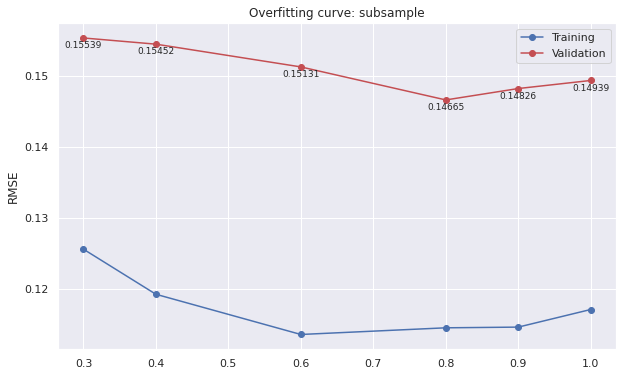

In [ ]:
xgb_test_param_and_plot('subsample', [.3, .4,.6,.8,.9,1])

The optimal parameter value seems to be 0.8.

**max_delta_step** defines each tree’s weight estimation.  This parameter alleviates the adverse impacts of extreme class imbalance.  

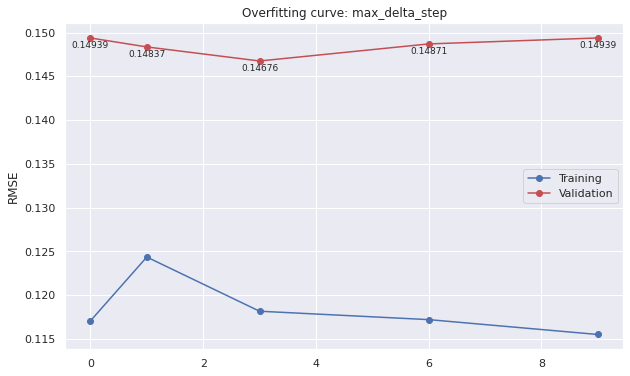

In [ ]:
xgb_test_param_and_plot('max_delta_step', [0,1,3,6,9]) 

It is unclear what the optimal 'max_delta_step' value is due to unusual behavior of the training data.   The value will be set to 3 as it seems more conservative.

**booster** is the type of training, prediction & evaluation routine usede by the gradient boosting algorithm. 

It seems 'gbtree' & 'dart' delivers about the same result.  The default value of 'gbtree' will be used.

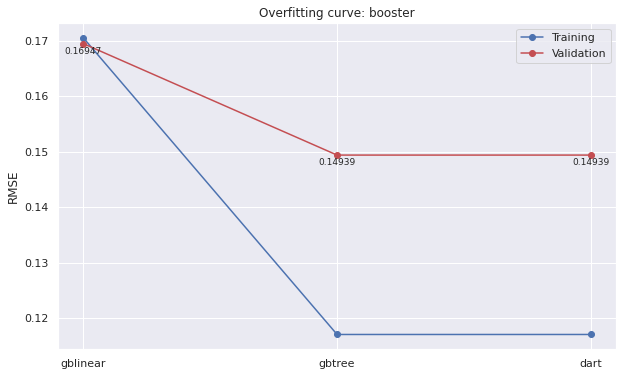

In [ ]:
xgb_test_param_and_plot('booster', ['gblinear', 'gbtree', 'dart'])

### **Putting it together - XGBoost Model**

Based on the hyperparameter tuning learning, we put them all together for the final model.  

In [ ]:
%%time
xgb_trans_model = XGBClassifier(n_jobs=-1, 
                      random_state=42,
                      n_estimators = 125,
                      max_depth=8, 
                      eta = .4,
                      alpha=.5,
                      gamma=.5,
                      subsample=.8,
                      max_delta_step=3
                       )

CPU times: user 32 µs, sys: 23 µs, total: 55 µs
Wall time: 56.7 µs


We will be using the same split data from RandomForest model evaluation.

In [ ]:
%%time
xgb_trans_model.fit(X_train_t_inputs, X_train_t_targets)

CPU times: user 43min 41s, sys: 10.4 s, total: 43min 51s
Wall time: 11min 54s


XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4, eval_metric=None,
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=3, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=125, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
xgb_train_t_acc = xgb_trans_model.score(X_train_t_inputs, X_train_t_targets)
xgb_val_t_acc = xgb_trans_model.score(X_val_t_inputs, X_val_t_targets)
print('Hyper-tuned Model: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(xgb_train_t_acc*100, xgb_val_t_acc*100))

Hyper-tuned Model: Train Accuracy Score: 99.142028%, Val Accuracy Score: 98.344566%


**Hyper-tuned Model: Train Accuracy Score: 99.734932%, Val Accuracy Score: 98.479358%

In [ ]:
print('BaseModel for Trans Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(xgb_base_train_t_acc *100, xgb_base_val_t_acc*100))

BaseModel for Trans Data: Train Accuracy Score: 98.629503%, Val Accuracy Score: 97.768144%


Hyper-parameter tuning has improved the model performance by 0.71%

In [ ]:
xgb_trans_model_importance_df = pd.DataFrame({
    'feature': X_train_t_inputs.columns,
    'importance': xgb_trans_model.feature_importances_
}).sort_values('importance', ascending=False)

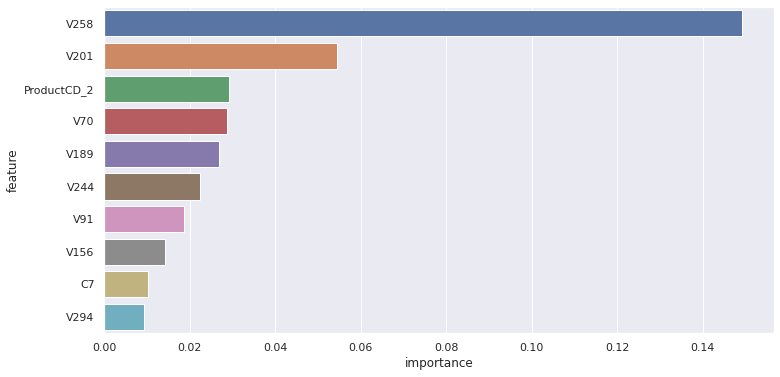

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=xgb_trans_model_importance_df.head(10), x='importance', y='feature');


In [ ]:
trees = xgb_trans_model.get_booster().get_dump()
print(trees[1][:3000])

0:[V258<0.037878789] yes=1,no=2,missing=1
	1:[V189<0.0500000045] yes=3,no=4,missing=3
		3:[V294<0.000388802495] yes=7,no=8,missing=7
			7:[C14<0.000349895039] yes=15,no=16,missing=15
				15:[C1<0.000533617917] yes=29,no=30,missing=29
					29:[card3_V258_mean<0.0336069837] yes=57,no=58,missing=57
						57:[V154<0.0833333358] yes=109,no=110,missing=109
							109:[P_R_emaildomain_match_False<0.5] yes=197,no=198,missing=197
								197:[ProductCD_4<0.5] yes=319,no=320,missing=319
									319:[card2_transAmt_t_stat<0.0149669796] yes=489,no=490,missing=489
										489:[P_emaildomain_5<0.5] yes=697,no=698,missing=697
											697:[V139<0.0151515156] yes=935,no=936,missing=935
												935:leaf=0.157084301
												936:leaf=-0.480761766
											698:[addr1_transAmt_t_stat<0.0132645564] yes=937,no=938,missing=937
												937:leaf=0.433751911
												938:leaf=-0.321173102
										490:[card1_transAmt_t_stat<0.0261397604] yes=699,no=700,missing=699
											699:[card3_tra

In [ ]:
xgb_X_test_trans_preds = xgb_trans_model.predict(X_test_trans)

In [ ]:
test_t_index = test_trans[['TransactionID']]
submission_t_xgb = pd.DataFrame(data = xgb_X_test_trans_preds, 
                  columns = ['isFraud'])
submission_t_xgb = test_t_index.join(submission_t_xgb)
submission_t_xgb.sample(10)

,TransactionID,isFraud
171061,3834610,0
198789,3862338,0
26517,3690066,0
211638,3875187,0
483567,4147116,0
336088,3999637,0
275445,3938994,0
171645,3835194,0
341174,4004723,0
175064,3838613,0


## **XGBoost Model Building for Identity Data**

In [ ]:
xgb_base_id = XGBClassifier(n_jobs=-1, random_state=42)
print(xgb_base_id)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [ ]:
%%time
xgb_base_id.fit(train_i_inputs,train_i_targets)

CPU times: user 1min 44s, sys: 543 ms, total: 1min 45s
Wall time: 28.6 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
xgb_base_train_i_acc = xgb_base_id.score(train_i_inputs,train_i_targets)
xgb_base_val_i_acc = xgb_base_id.score(val_i_inputs, val_i_targets)
print('BaseModel for Trans Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(xgb_base_train_i_acc *100, xgb_base_val_i_acc*100))

BaseModel for Trans Data: Train Accuracy Score: 99.144884%, Val Accuracy Score: 97.178314%


In [ ]:
xgb_i_base_importance_df = pd.DataFrame({
    'feature': train_i_inputs.columns,
    'importance': xgb_base_id.feature_importances_
}).sort_values('importance', ascending=False)

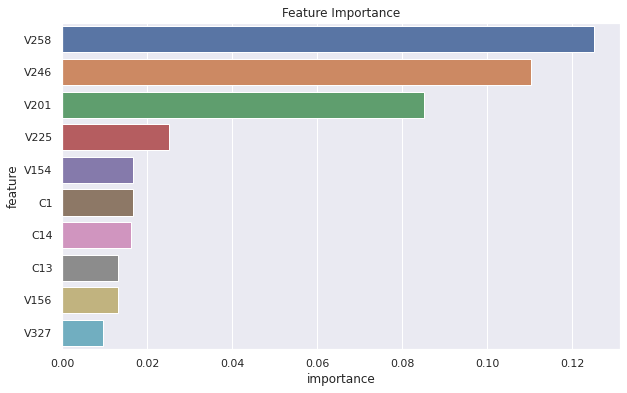

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=xgb_i_base_importance_df.head(10), x='importance', y='feature');

In [ ]:
#RandomForest hyper-parameter tuned model importance
xgb_trans_model_importance_df.head(10)

,feature,importance
243,V258,0.155623
361,ProductCD_2,0.095995
141,V156,0.025788
359,ProductCD_0,0.022880
109,V91,0.022867
231,V246,0.022017
92,V70,0.019887
174,V189,0.014927
139,V154,0.013875
274,V294,0.011958


Result from the XGBoost basemodel for the Transaction data is different from the oe based on the identity data.  However, both models again chose V258 as the most powerful feature. 



### **Hyperparameter Tuning**


In [ ]:
#Defining the train_inputs, train_target, val_inputs & val_targets definitions
train_inputs = train_i_inputs
train_targets = train_i_targets
val_inputs = val_i_inputs 
val_targets = val_i_targets

**max_depth** specifies the maximum depth of each tree in XGBoost trees.

CPU times: user 22min 3s, sys: 7.52 s, total: 22min 11s
Wall time: 6min 2s


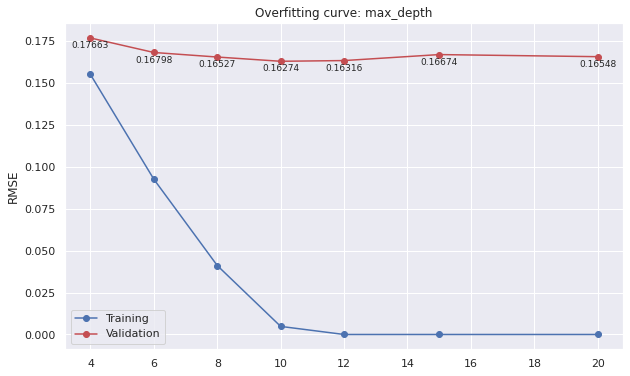

In [ ]:
%%time
xgb_test_param_and_plot('max_depth', [4, 6, 8, 10, 12, 15, 20])

The optimal parameter seems to be 10.

**n_estimators**

CPU times: user 10min 14s, sys: 4.5 s, total: 10min 18s
Wall time: 2min 52s


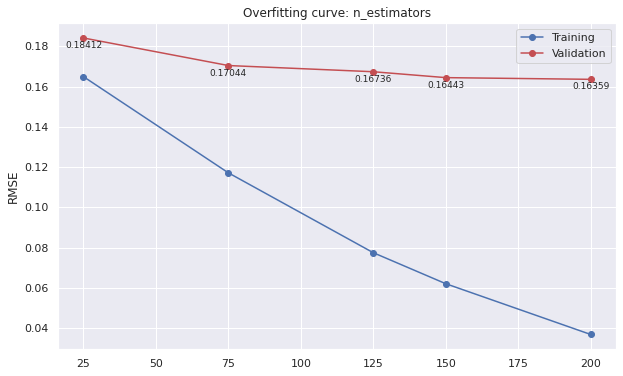

In [ ]:
%%time
xgb_test_param_and_plot('n_estimators', [25, 75, 125, 150, 200])

Higher the n_estimators, greater the accuracy. There seems to be little difference between the n_estimator=150 vs 200.  Hence the parameter value will be set at 150.

**Learning Rate** is inserted to limit the learning rate of gradient boosted deicion trees, thereby limiting the possibility of overfitting. 

CPU times: user 12min 22s, sys: 5.63 s, total: 12min 28s
Wall time: 3min 29s


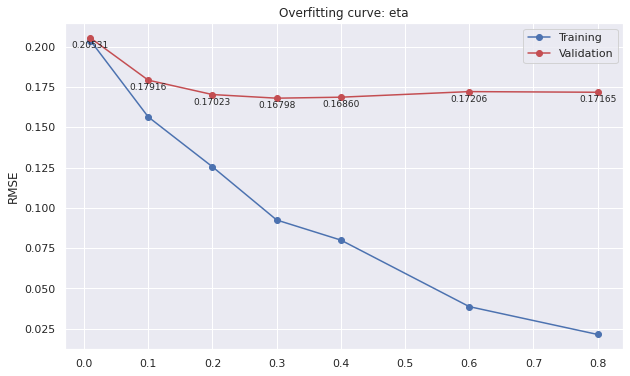

In [ ]:
%%time
xgb_test_param_and_plot('eta', [.01, .1, .2, .3, .4, .6, .8])

The optimal 'learning_rate', aka 'eta', seems to be 0.3

**gamma** specifies the minimum loss reduction required to make a split. A node is split only when the resulting split gives a positive reduction in the loss function.
Hence high parameter value of gamma makes the algorithm conservative. 

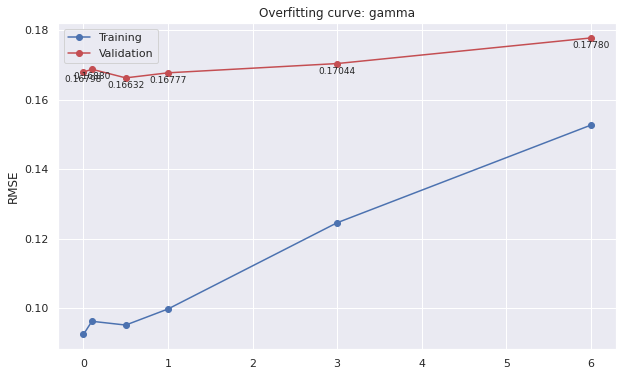

In [ ]:
xgb_test_param_and_plot('gamma', [0, 0.1, 0.5, 1, 3, 6])

The optimal value of gamma seems to be 0.5. 

**alpha** defines the L1 (Lasso regression) regularization term weights.  It can be used in case of very high dimensionality so that the algorithm runs faster when implemented.

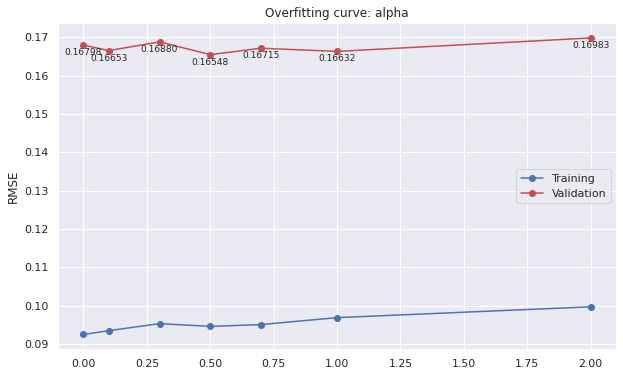

In [ ]:
xgb_test_param_and_plot('alpha', [0,.1,.3,.5,.7,1,2])

It is unclear what the optimal alpha parameter value is.  For now, the 0.5 will be chosen. 

**subsample** denotes the fraction of observations to be randomly samples for each tree.

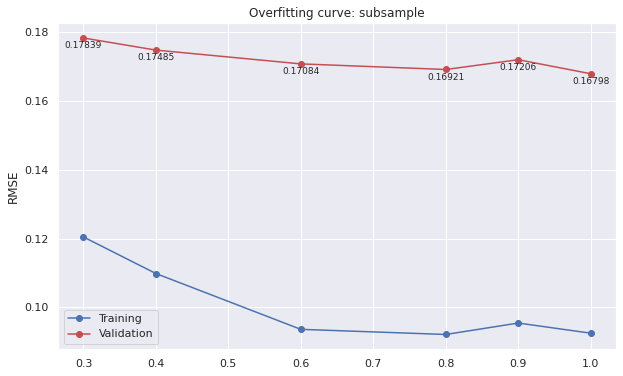

In [ ]:
xgb_test_param_and_plot('subsample', [.3, .4,.6,.8,.9,1])

The optimal parameter value seems to be 0.8.

**max_delta_step** defines each tree’s weight estimation.  This parameter eleviates the adverse impacts of extreme class imbalance.  

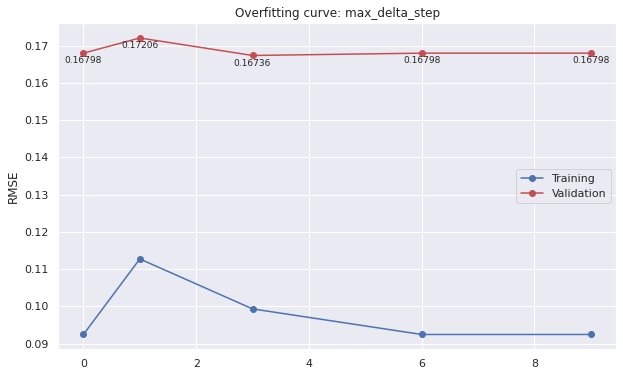

In [ ]:
xgb_test_param_and_plot('max_delta_step', [0,1,3,6,9]) 

It is unclear what the optimal 'max_delta_step' value is due to unusual behavior of the training data.   The value will be set to 3 as it seems more conservative.

**booster** is the type of training, prediction & evaluation routine usede by the gradient boosting algorithm. 

It seems 'gbtree' & 'dart' delivers about the same result.  The default value of 'gbtree' will be used.

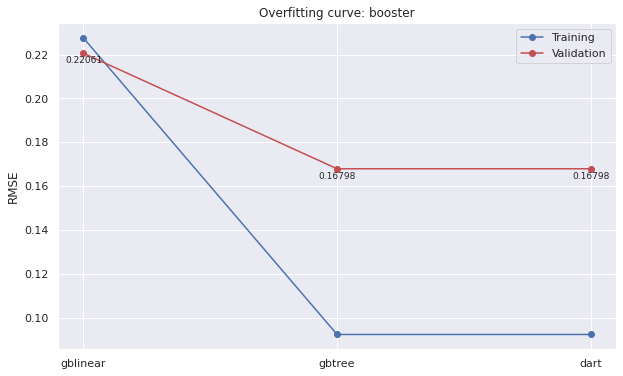

In [ ]:
xgb_test_param_and_plot('booster', ['gblinear', 'gbtree', 'dart'])

### **Putting it together - XGBoost Model**

Based on the hyperparameter tuning learning, we put them all together for the final model.  

In [ ]:
%%time
xgb_id_model = XGBClassifier(n_jobs=-1, 
                      random_state=42,
                      n_estimators=150,
                      max_depth=10, 
                      eta = .3,
                      gamma=.5,
                      subsample=.8,
                      max_delta_step=3, 
                      alpha=.5 )

CPU times: user 91 µs, sys: 1 µs, total: 92 µs
Wall time: 96.3 µs


We will be using the same split data from RandomForest model evaluation.

In [ ]:
%%time
xgb_id_model.fit(X_train_i_inputs, X_train_i_targets)

CPU times: user 18min 7s, sys: 2.57 s, total: 18min 9s
Wall time: 4min 52s


XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=3, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
xgb_train_i_acc = xgb_id_model.score(X_train_i_inputs, X_train_i_targets)
xgb_val_i_acc = xgb_id_model.score(X_val_i_inputs, X_val_i_targets)
print('Hyper-tuned Model: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(xgb_train_i_acc*100, xgb_val_i_acc*100))

Hyper-tuned Model: Train Accuracy Score: 99.975965%, Val Accuracy Score: 97.878477%


In [ ]:
print('BaseModel for Trans Data: Train Accuracy Score: {0:3f}%, Val Accuracy Score: {1:3f}%'.format(xgb_base_train_i_acc *100, xgb_base_val_i_acc*100))

BaseModel for Trans Data: Train Accuracy Score: 99.144884%, Val Accuracy Score: 97.178314%


Hyper-parameter tuning has improved the model performance by 0.70%

In [ ]:
xgb_id_model_importance_df = pd.DataFrame({
    'feature': X_train_i_inputs.columns,
    'importance': xgb_id_model.feature_importances_
}).sort_values('importance', ascending=False)

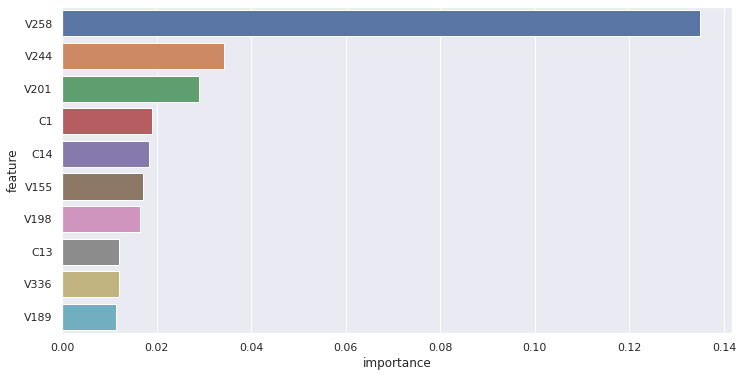

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=xgb_id_model_importance_df.head(10), x='importance', y='feature');

In [ ]:
xgb_trans_model_importance_df.head(10)

,feature,importance
243,V258,0.149160
186,V201,0.054408
361,ProductCD_2,0.029267
92,V70,0.028655
174,V189,0.026852
229,V244,0.022354
109,V91,0.018678
141,V156,0.014151
13,C7,0.010203
274,V294,0.009288


In [ ]:
trees = xgb_id_model.get_booster().get_dump()
print(trees[1][:3000])

0:[C1<0.00117395935] yes=1,no=2,missing=1
	1:[V201<0.0454545468] yes=3,no=4,missing=3
		3:[C14<0.000349895039] yes=7,no=8,missing=7
			7:[C1<0.000533617917] yes=15,no=16,missing=15
				15:[card2_V258_mean<0.0537355319] yes=31,no=32,missing=31
					31:[V155<0.0625] yes=59,no=60,missing=59
						59:[ProductCD_transAmt_t_stat<0.0975717008] yes=107,no=108,missing=107
							107:[id_17<0.744186044] yes=183,no=184,missing=183
								183:[V197<0.107142866] yes=275,no=276,missing=275
									275:[id_03<0.717391312] yes=399,no=400,missing=399
										399:leaf=-0.413180083
										400:leaf=0.138034776
									276:[id_14_transAmt_t_stat<0.0308305174] yes=401,no=402,missing=401
										401:leaf=-0
										402:leaf=0.336244226
								184:[card1_V258_std<0.0267209578] yes=277,no=278,missing=277
									277:[V139<0.0151515156] yes=403,no=404,missing=403
										403:leaf=0.176397502
										404:leaf=-0.40385133
									278:[card1<0.74465394] yes=405,no=406,missing=405
										405:l

In [ ]:
xgb_X_test_id_preds = xgb_id_model.predict(X_test_id)

In [ ]:
test_i_index = test_id[['TransactionID']]
submission_i_xgb = pd.DataFrame(data = xgb_X_test_id_preds, 
                  columns = ['isFraud'])
submission_i_xgb = test_i_index.join(submission_i_xgb)
submission_i_xgb.sample(10)

,TransactionID,isFraud
123487,4136449,0
133830,4152016,0
119827,4130017,0
55822,3942695,0
130009,4146870,0
61229,3962845,0
112321,4116899,0
92904,4072811,0
26437,3806651,0
36714,3865220,0


# **Preparing the Submission Files**

The four submission files in dataframe object are:

* rf_submission_trans_df >> RandomForest Transaction data based predictions
* rf_submission_id_df >> RandomForest Identity data based predictions
* submission_t_xgb >> XGBoost Transaction data based predictions
* submission_i_xgb >> XGBoost Identity data based predictions

Identity data based predictions are deemed to be superior since the identity data is merged with the transaction data.  However, the length of identity data is again only 1/4 of the transaction data.  Therefore, approximately 1/4 of the prediction will be based on the identity + transaction data while the remainder is based on the transaction data only. 

Below is the code to combine the two predictions:

In [ ]:
rf_submission = rf_submission_trans_df.merge(rf_submission_id_df, how='left', on='TransactionID')

In [ ]:
rf_submission['isFraud'] = np.where(rf_submission['isFraud_y'].isnull() == True, rf_submission['isFraud_x'], rf_submission['isFraud_y'])

In [ ]:
rf_submission.drop(['isFraud_x', 'isFraud_y'], axis=1, inplace=True)

In [ ]:
xgb_submission = submission_t_xgb.merge(submission_i_xgb, how='left', on='TransactionID')

In [ ]:
xgb_submission['isFraud'] = np.where(xgb_submission['isFraud_y'].isnull() == True, xgb_submission['isFraud_x'], xgb_submission['isFraud_y'])
xgb_submission.drop(['isFraud_x', 'isFraud_y'], axis=1, inplace=True)

In [ ]:
xgb_submission.to_csv('xgb_submission.csv', index=False)
rf_submission.to_csv('rf_submission.csv', index=False)

# **Result & Conclusion**

## **Competition Submission Result & Analysis**

The predicted results from RandomForest and XGBoost models were submitted to the Kaggle competition.  Not surprisingly, the results are poor, likely placing me in the bottom quartile.  More creative feature engineering and more detailed hyperparameter tuning would be required to improve the models.  

One interesting observation is that RainForest model had slightly better score.  XGBoost is commonly considered by many as superior ML model. The poor performance can only be attributed to the inexperienced model-builder. 

<img src="https://imgur.com/OXP5ge9.jpg"  width="600" height="300">



Below is a table of the accuracy scores.

One might expect that the predictio based on the merged identity data would be more accurate than the one based on the transaction data only.  The finding is the contrary - the predictions based on the transaction data are more accurate. 

<img src="https://imgur.com/i7qvJ7x.jpg"  width="400">





----------------------------------


Examination of the Feature Importance tables reveals a few interesting observations:
* All models picked up 'V258' * 'C1' as one of the most important features.  
* My attempt to feature engineer 'V258' failed to make a meaningful contribution.
* Transaction data in both models seem to have more predictive power.  While the merged identity data may have greater scope of data, the transaction data with four-fold more data has more depth.  Depth of data may be more important than the scope. 

**Random Feature Importance**
<br>

RF Transaction  | RF Identity
-------------------|------------------
<img src="https://imgur.com/SuZGAnk.jpg" width="400" />      | <img src="https://imgur.com/jhhGDLb.jpg" width="400" /> 


**XGBoost Feature Importance**
<br>

XGBoost Transaction  | XGBoost Identity
-------------------|------------------
<img src="https://imgur.com/ss2DjNh.jpg" width="400" />      | <img src="https://imgur.com/bLX92g1.jpg" width="400" /> 


Let us have a closer examination of 'V258':

In [ ]:
train_raw.V258.value_counts(dropna=False).head(10)

NaN    460110
1.0    112953
2.0     11247
3.0      2696
4.0      1062
5.0       569
6.0       368
7.0       280
8.0       214
9.0       147
Name: V258, dtype: int64

Below is a summary of 'V258'.  The data is extracted from the Excel sheet from the earlier EDA - IEEE_C_Card_Fraud_Worksheet.xlsx

V258 has 78% null values but the fraud rate within the null population is only 2.27% vs. 7.81% in non-null population.  Mode of V258 is "1" with the fraud rate of 3.97% which is still higher than 3.5% average.  But the fraud rate increases as the feature values increase, reaching 78.21% when the value becomes 5.  In addition, as the frequency of value occurance increase so does the fraud rate. 

<img src="https://imgur.com/nc0hJ9B.jpg"  width="300">

## **Future Work**

*  **Feature engineering idea**: the data is a series of credit card transactions, and one could assume that customers made multiple transactions. If one could find a way to identity and group these transactions to their respective customers then we may be able to identify not just fraudulent transactions but the fraudsters themselves.  This would be a powerful predictor of future fraud.  After all, it is fraudsters that commit frauds. 

*  **Hyperparameter Tuning**: due to limited computing resource and time, I was able to further fine tune the parameters.  In particular, it would have been interesting to observe how different parameters interact with each other.  Is there pattern to how different parameters interacts with each other regardless of dataset type or characteristics. 



## **Credits & References**

*  GeekforGeek.org & stackoverflow.com >> provided short & quick answers & examples whenever I ran into coding issues.

*  www.analyticsvidhya.com >> again when I needed quick yet well summarized understanding on ML issues such as MissForest, XGBoost, K-Fold validation, this website has been tremendous help. 

*  Jovian community & instructions with special mention of the following instructors - Samanvitha Bayaneni, Biraj De, Aakash N S & Himani Gulati - who have been always ready to lend hand.  I thank you!

